# Analysis of the influence of ratings in Amazon reviews

#### Authors:
- Fernández, David
- Virey, Briac

## 1. Accessing data

Our main Dataset is the Amazon one, that is based on its reviews for almost 20 years. It's about 20 GB, but we won't use all it's information at the same time so we are going to work localy on our computers.

First thing we do is to explore data. We have many possibilities deppending on what we want to do, main files are:
* __Raw data__: with all the data from the Amazon's reviews, which is 20GB compressed and about 100GB decompressed.
* __Ratings only__: this iloe contains the ratings from reviews with some information such us the product identification(_asin_) but not the reviews text, which might be unnecessary for us.
* __5-core__: this one is as the fist one but only contains those reviews and users with more than 5 reviews, so it results in a smaller dataset, compressed it's 10GB.
* __5-core - By category__: this is the _5-core_ file divided by category so we can do our analysis by category instead of by products or reviewer without using metadata for that. 
* __Metadata__: which contains data about reviews as some _images_, _also bought products_, etc. It's about 3GB compressed and 10GB decompressed.

With this information, we see wether we should work on our own computers or if we need to use the cluster. We do some tests with the raw data and the other files and we get some conclusions, as it was predicted, if we need data to be stored in memory we can't use our computers, but if we only need some pieces of information from these files, as we have others smaller (_the one's divided by category_) we can do it.

So after this test is about time to think which are going to be our questions for the project, to review the one's we had and to see if they are suitable with the actual knownledge. Also to decide if using the cluster would be a good option taking into account the pros and the cons.

Once we have done our exploratory analysis about data we are going to resume how data is and how we access. Mainly we have two types of data, the __ratings__ and the __metadata__ and we access them in a different way. 
* __ratings__ are in separated files, divided by the category of the product, their extension is _.csv_ and we load them in memory by using *import_csv* created by us.
* __metadata__ is an unique file that we rarely use so we don't allocate it on memory, when we want to access to some of its information we parse it with a _parse()_ function got from the data source.

<br><br>*Note that some of the prints hidden are mainly use for execution control* 

Our accessing fuctions and imports needed are below, *import_csv(path, header)* and *parse(path)*.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import gzip 
from datetime import datetime as dt
from collections import Counter
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

In [2]:
#@param path
#    the path of the file we want to import
#@param headers
#    the names of the headers that the dataset will have
#@retun 
#    the dataset from the csv file
def import_csv(path, headers):
    return pd.read_csv(path, header=None, names=headers)

In [3]:
#@param path
#    the path of the file we want to import
#@retun 
#    the string to be converted to json with the object
def parse(path):
    g = gzip.open(path, 'r')
    for l in g: 
        yield json.dumps(eval(l))

<br><br>
# 2. Exploratory analysis

We will work with two main datasets, a list of categories and a list of dataframes with the ratings for each category. 

In [4]:
# Path for the ratings files
mypath_ratings="data/ratings" 
# Getting files
rating_files = [f for f in listdir(mypath_ratings) if isfile(join(mypath_ratings, f))]
# Taking out the file extension
rating_categories = [x[8:-4].replace('_', ' ') for x in rating_files] 
# Headers as input to create the dataframes
headers = [ "reviewerID","asin","rating","timestamp"] 
#Number of categories
num_categories = len(rating_categories)

In [5]:
rating_df = [import_csv(mypath_ratings + '/' + file, headers) for file in rating_files]

ratings = list(zip(rating_categories, rating_df))

Now that we have the main data, we are going to start exploring it.

### Plotting data

In order to have a general idea about how data is, to be able to solve our analysis questions and to serve as a guide, we are going to plot some important data.

#### 2.1 Reviews per category

We are going to start by ploting main information to explore data, such as the number of reviews per category and how relevant a category is in the whole dataframe.


In [6]:
# Initialize the variables needed
reviews_number_cat=[] # Number of reviews per category
reviews_products_cat=[] # Number of unique products per category

# We iterate over all ratings to get the number of reviews.
for i in range(0,len(rating_files)):
    reviews_number_cat.append(len(ratings[i][1]))
    reviews_products_cat.append(len(ratings[i][1]['asin'].unique()))


##### Absolute data

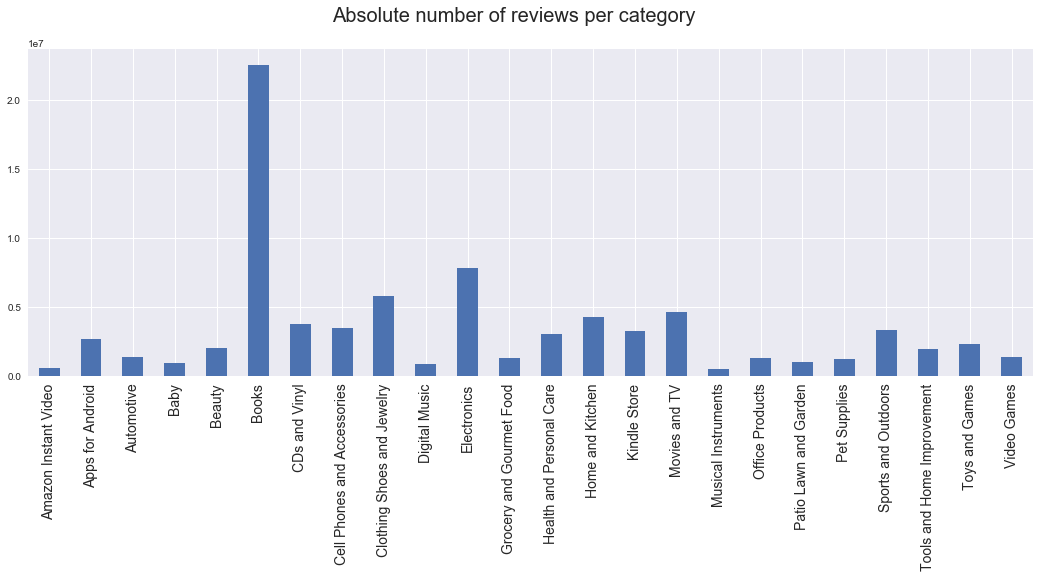

In [7]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
fig.canvas.draw()

pd.DataFrame(reviews_number_cat)[0].plot(kind='bar')

fig.suptitle('Absolute number of reviews per category', fontsize=20)
ax.set_xticklabels(rating_categories, fontsize=14)

plt.show()

In the graph above, we can see the total number of reviews for each category. 

The *Books* category is by far the one with most reviews. This said, we need to take into account the total number of product per category (relative number of review). Indeed, there are more books proposed on Amazon.com than musical instruments.

##### Relative data

Data as a percentage of the total number of reviews per product per category.

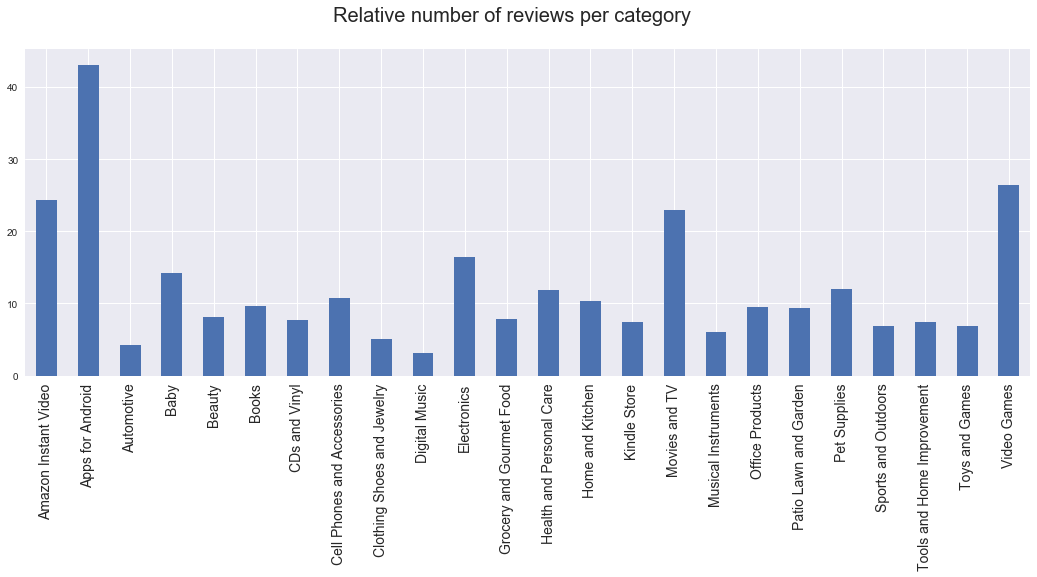

In [8]:
# The main difference with the previous one is that we need a set of the products per category to get 
    # its length so that we can divide  the number of reviews/number of differents products.
    
# Relative number of reviews per product per category
reviews_relative_cat = [reviews_number_cat[i]/reviews_products_cat[i] for i in range(0, len(reviews_number_cat))] 

# Plots
fig, ax = plt.subplots(figsize = (18,6))
fig.canvas.draw()

pd.DataFrame(reviews_relative_cat)[0].plot(kind='bar')

fig.suptitle('Relative number of reviews per category', fontsize=20)
ax.set_xticklabels(rating_categories, fontsize=14)

plt.show()

The overall look is totally different now that we consider the relative number of review per category.

The category with the highest value is *Apps for Android*. This might be explained by the fact that when you download an app on a mobile, you can instantly comment the product.
The *Books* category has a much lower value, possibly due to the fact that there is a really important number of books compared to other products.

The value range is much smaller. Considering every categories, the values tend to be more homogeneous.

#### 2.2 Overall ratings results
<br />
A quick view of how people rate products.

##### Values for all data


In [ ]:
overall_possibilities = 5 #Possible ratings
overall_frequency = [0]*overall_possibilities

for i in range(num_categories):
    c = Counter(ratings[i][1]['rating'].astype(int))
    for j in c.keys():
        overall_frequency[j.astype(int)-1] += c[j]

The above cell allows us to count the number of occurences of each rating. The cell below plots these results.

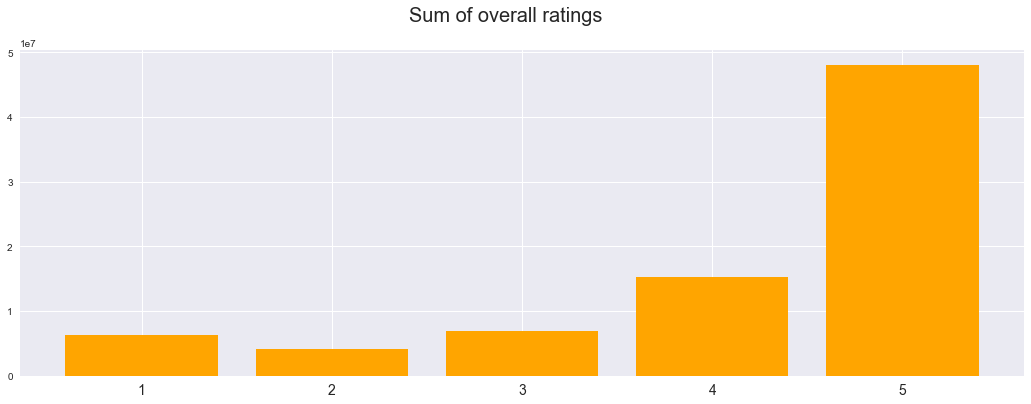

In [10]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Sum of overall ratings', fontsize=20)
plt.bar(range(1, overall_possibilities + 1),overall_frequency, color='orange')
ax.set_xticklabels(range(0, overall_possibilities + 1), fontsize=14)
plt.show()

The distribution of ratings is far from a normal distribution. The rating *5* is preferred has it has almost 3 times more reviews than the second more abundant rating.

This will influence the quality of the reviews. Indeed, if the ratings are not reflecting a true satisfaction, then, either reviewers don't comment when they are disappointed or the high ratings are due to bots. In those cases, the comments would be biased. 


##### Values per category

We repeat the same process, but this time for each category.

In [11]:
overall_cat=[]

for i in range(num_categories):
    overall_cat.append(ratings[i][1]['rating'])

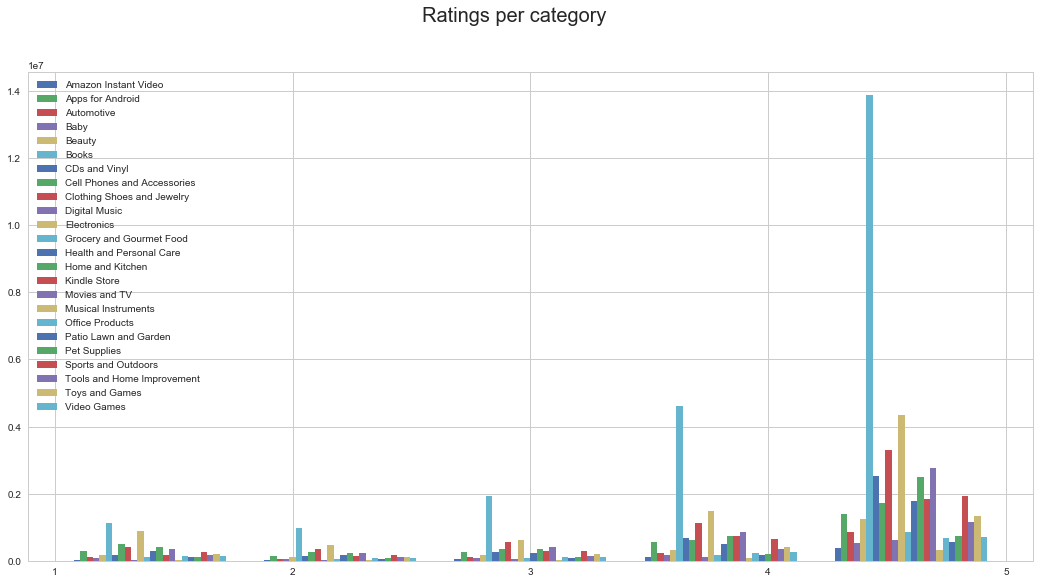

In [15]:
fig, ax = plt.subplots(figsize = (18,9))
plt.suptitle('Ratings per category', fontsize=20)
sns.set_style('whitegrid')
plt.hist(overall_cat, bins=5)
ax.set_xticks([1, 2 ,3 ,4, 5])
ax.legend(rating_categories)
plt.show()

Once again, this graph considers only the absolute number of ratings for each category.

The *Books* category is once more the most abundant for every ratings but it seems like each category follows the same trend.

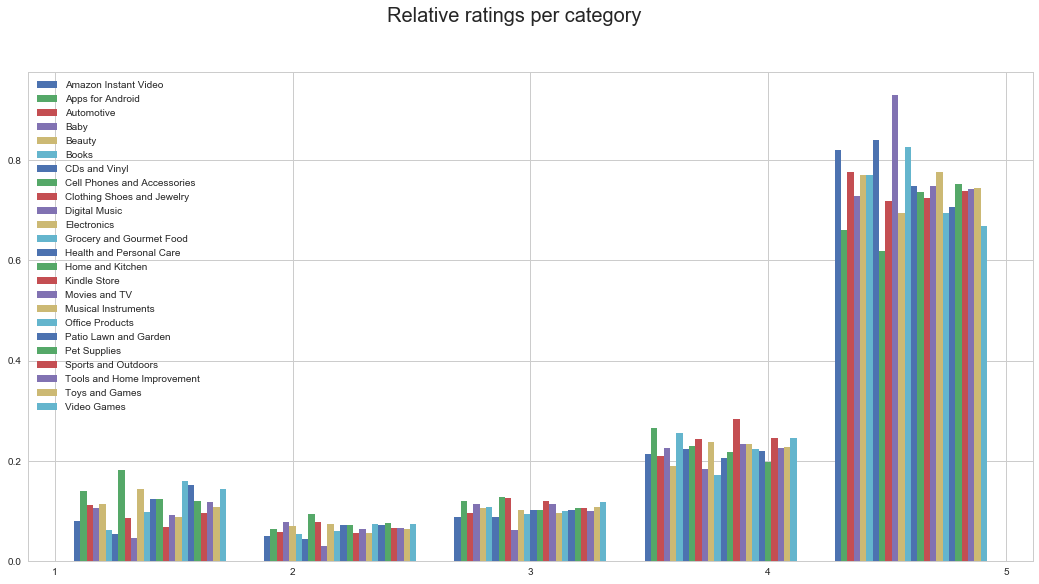

In [16]:
fig, ax = plt.subplots(figsize = (18,9))
sns.set_style('white')
plt.suptitle('Relative ratings per category', fontsize=20)
plt.hist(overall_cat, normed = True, bins=5)
ax.set_xticks([1, 2 ,3 ,4, 5])
ax.legend(rating_categories)

plt.show()

Getting the relative number of ratings per product, we can see that every category follows strictly the same trend. The rating *5* is always dominant, by far.

#### 2.3 Evolution of reviews per year

<br>How has the amount of reviews changed along time?


In [6]:
years_cat = [[] for i in range(num_categories)] #List of every year of each review per category

#We do this because we need the list for the next section (articles/year)
    # Go through every category, then every review and include the year of the review to a list.
for i in range (num_categories):
    for j in range(len(rating_df[i])):
        years_cat[i].append(dt.fromtimestamp(rating_df[i]['timestamp'][j]).year)


In [7]:
year_frequency = {} #Dict with keys as years and values as frequency of appearance for the entire data

#Create a list of counters that contains as key the year of the review and by value the frequency of 
    # that year in the list.
for i in range(num_categories):
    c = Counter(years_cat[i])
    for j in c.keys():
        if j in year_frequency:
            year_frequency[j] += c[j]
        else:
            year_frequency[j] = c[j]


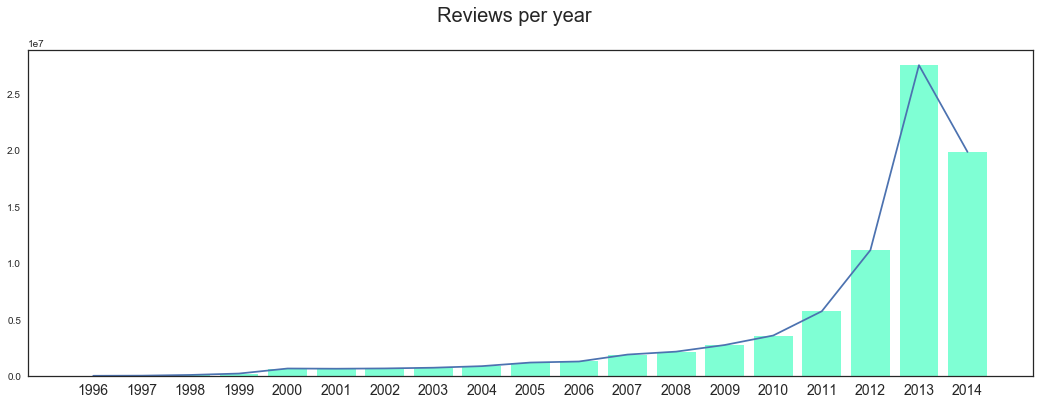

In [19]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Reviews per year', fontsize=20)
x, y = zip(*sorted(year_frequency.items())) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.bar(x,y, color='aquamarine')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=14)
plt.show()

We can see that the distribution seems to follow an exponential fuction, with a high increase for the last five years and a maximun for 2013.
To check the exponential increase we are going to plot the same graph with the y-axis _log_.

The low in the year 2014 might be due to the fact that the dataset stops in the middle of the year (July 2014).

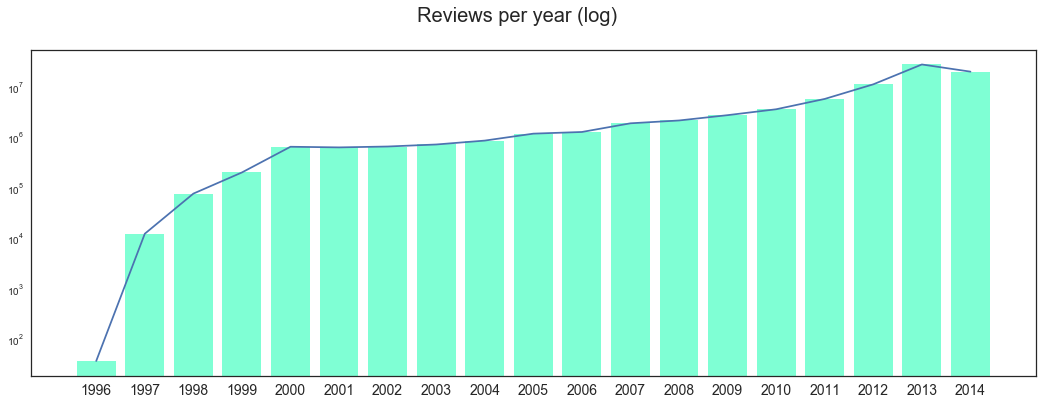

In [20]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Reviews per year (log)', fontsize=20)
x, y = zip(*sorted(year_frequency.items())) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.bar(x,y, color='aquamarine')
ax.set_yscale('log')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=14)
plt.show()

What stands out from this graph is the fact that from 2000 to 2013, where the maximum is, it fits well an exponential function, getting over the previous year’s values.
<br>
<br>

#### 2.4 Evolution of the number of rated products per year
<br>

We have seen that the number of reviews has increased almost every year, but, has the number different products rated followed the same tendency?
<br>



For this plot we need to manipulate data. 
Strategy is to create a lis of sets (one set per year) with every different product reviewd by year. And then use a Counter to get the values needed.

In [76]:
c_year_product = Counter()

for year in list(range(1996, 2015)):
    dict_year_product = set()

    for category in (range(num_categories)):
        i = 0
        for act_year in years_cat[category]:
            if (year == act_year):
                dict_year_product.add((rating_df[category]['asin'])[i])
            i += 1
        

    c_year_product[year] = Counter(dict_year_product)

c_year_product

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
1996
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
1997
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
1998
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
1999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2001
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2002
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2003
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2006
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2007
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2008
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2009
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Counter({1996: Counter({'002907052X': 1,
                  '0060975776': 1,
                  '0099740915': 1,
                  '0140146687': 1,
                  '0140231021': 1,
                  '0151179875': 1,
                  '0156421356': 1,
                  '0195038630': 1,
                  '0312039506': 1,
                  '0312853238': 1,
                  '0345324412': 1,
                  '0345361326': 1,
                  '0345409469': 1,
                  '0374528284': 1,
                  '0385313861': 1,
                  '0393316041': 1,
                  '0446320277': 1,
                  '044651862X': 1,
                  '0451188462': 1,
                  '0553092626': 1,
                  '0571129471': 1,
                  '0671003755': 1,
                  '0671536109': 1,
                  '0671787381': 1,
                  '0679740244': 1,
                  '0756400430': 1,
                  '0806128887': 1,
                  '0812530756': 1,
              

In [83]:
c_year_product_2 = {}
for year in c_year_product.keys():
    c_year_product_2[year] = len(c_year_product[year])
    
c_year_product_2

{1996: 37,
 1997: 8788,
 1998: 43040,
 1999: 88677,
 2000: 220223,
 2001: 211618,
 2002: 211105,
 2003: 223684,
 2004: 261488,
 2005: 351495,
 2006: 404893,
 2007: 586238,
 2008: 684804,
 2009: 865671,
 2010: 1103307,
 2011: 1534657,
 2012: 2385218,
 2013: 4151754,
 2014: 3406405}

To check that the counter has worked as it was supposed we do some comparisons in the following two cells.

In [99]:
c_year_product_rep = Counter() #Number of products rated per year

for category in (range(num_categories)):
    c_year_product_rep += Counter(years_cat[category])

c_year_product_rep

Counter({1996: 37,
         1997: 12233,
         1998: 76231,
         1999: 200119,
         2000: 645884,
         2001: 627229,
         2002: 652965,
         2003: 716122,
         2004: 855418,
         2005: 1174086,
         2006: 1266707,
         2007: 1881450,
         2008: 2140543,
         2009: 2727906,
         2010: 3568865,
         2011: 5718074,
         2012: 11130176,
         2013: 27514214,
         2014: 19829302})

In [98]:
year_frequency

{1996: 37,
 1997: 12233,
 1998: 76231,
 1999: 200119,
 2000: 645884,
 2001: 627229,
 2002: 652965,
 2003: 716122,
 2004: 855418,
 2005: 1174086,
 2006: 1266707,
 2007: 1881450,
 2008: 2140543,
 2009: 2727906,
 2010: 3568865,
 2011: 5718074,
 2012: 11130176,
 2013: 27514214,
 2014: 19829302}

Now, let us plot the number of different products reviewed per year.

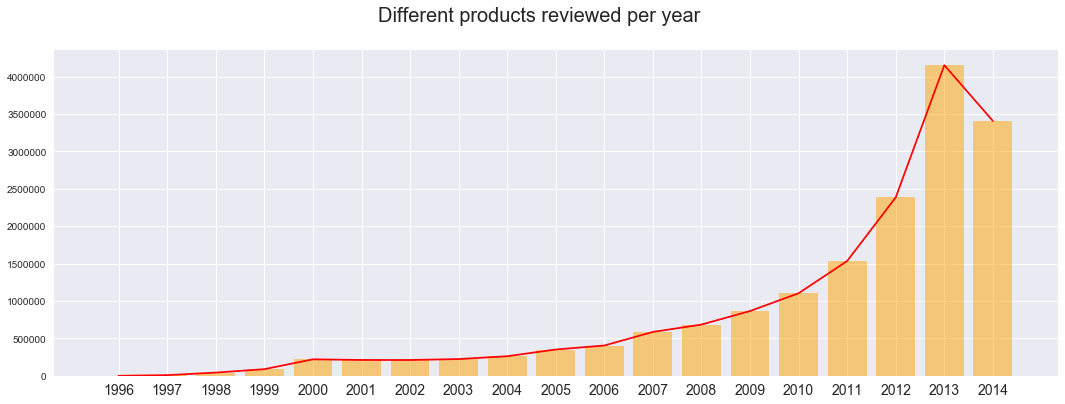

In [88]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Different products reviewed per year', fontsize='20')
x, y = zip(*sorted(c_products_rated_year.items())) # unpack a list of pairs into two tuples
plt.plot(x, y, color='red')
plt.bar(x,y, color='orange', alpha=0.5)

#ax.set_yscale('log')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize='14')
plt.show()

We can see that approximately 2003 it follows a logarithm fuction of increasing, so we are going to plot it with the y axis 'log'.

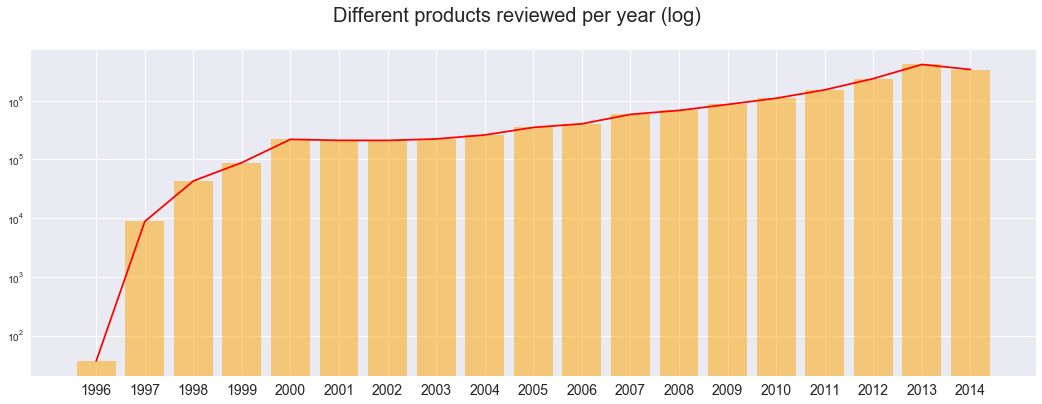

In [97]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Different products reviewed per year (log)', fontsize='20')
x, y = zip(*sorted(c_year_product_2.items())) # unpack a list of pairs into two tuples
plt.plot(x, y, color = 'red')
plt.bar(x,y, color='orange', alpha=0.5)
ax.set_yscale('log')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize='14')
plt.show()

We see that the tendency is really similar, obviously values are smaller but tendency, even with the maximum in 2013 and a decrease in 2014 are there.

#### Reviews vs products

As we have seen that the tendency is similar, is a good idea to plot them together and check how big is the number of reviews compared with the number of different products rated.

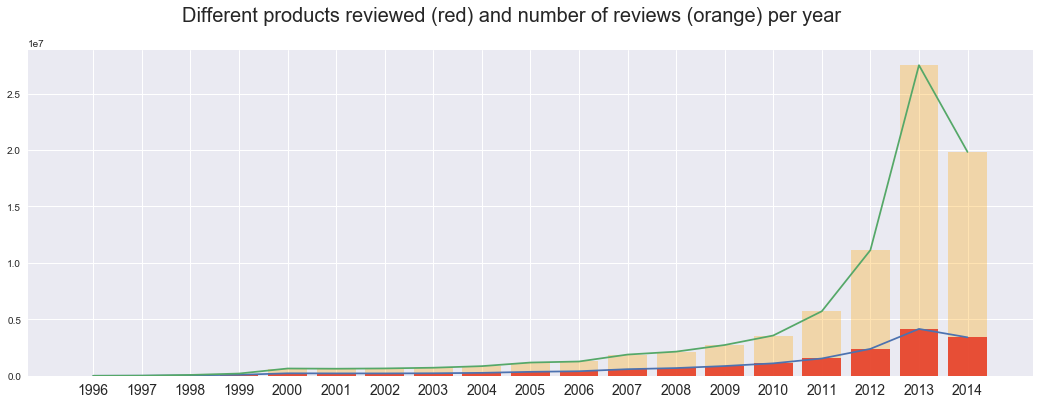

In [108]:
#Ploting evolution of reviews per year plus the evolution of the number of products reviewed per year:

# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Different products reviewed (red) and number of reviews (orange) per year ', fontsize = '20')
x, y = zip(*sorted(c_year_product_2.items())) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.bar(x,y, color='crimson', alpha=0.9)

x2, y2 = zip(*sorted(year_frequency.items())) # unpack a list of pairs into two tuples
plt.plot(x2, y2)
plt.bar(x2,y2, color='orange', alpha=0.3)

#ax.set_yscale('log')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize = '14')
plt.show()

Even though the two variables have a different increasing rate, the two trends are similar (logarithmic). 

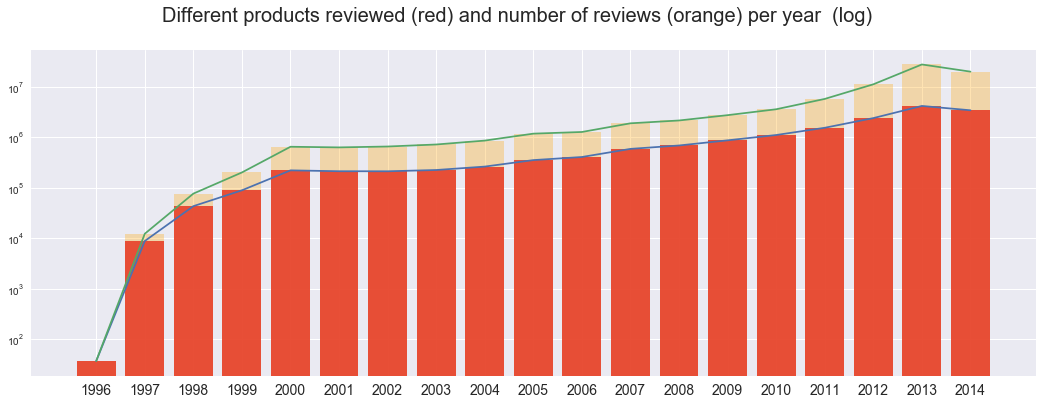

In [109]:
# With the y axis 'log' so that the great increase for the last years is not that big in the representation 
    # and that the difference for total products and total reviews wont seems to be that big 
    
    # Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Different products reviewed (red) and number of reviews (orange) per year  (log)', fontsize = '20')
x, y = zip(*sorted(c_year_product_2.items())) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.bar(x,y, color='crimson', alpha=0.9)

x2, y2 = zip(*sorted(year_frequency.items())) # unpack a list of pairs into two tuples
plt.plot(x2, y2)
plt.bar(x2,y2, color='orange', alpha=0.3)

ax.set_yscale('log')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize = '14')
plt.show()

We have also plotted data with _log y-axis_ to reduce big values and this allows us to see that the tendency, judging by plots, is related and that an improvement in ratings make an improvement in the number of different products rated.

<br><br>
# 3. Research questions

Once ploted the most important information, we are going to solve some of the questions that will take us to the final conclusions.
* __Q1:__ How has the amount of reviews changed during time? Is this constant on every category?
* __Q2:__ Is there relation between price of the product and the amount of reviews?
* __Q3:__ Is there relation between category of the product and the amount of reviews?
* __Q4:__ Are the people giving more reviews more satisfied with products?


<br>
## Q1: How has the amount of reviews changed during time? Is this constant on every category?

For solving this question, we will start by taking the plots from the previous analysis and adding, for example, some for interesting categories or an analysis of the amount of reviews per month, studding if it's constant or not.

### Evolution of reviews per year

We repeat the same steps followed before to start our analysis. But preparing data for next movements.

In [110]:
years_cat = [[] for i in range(num_categories)] #List of every year for category

#We do this because we need the list for the next section (articles/year)
    # Go through every category, then every review and include the year of the review to a list.
for i in range (num_categories):
    for j in range(len(rating_df[i])):
        years_cat[i].append(dt.fromtimestamp(rating_df[i]['timestamp'][j]).year)
  

year_frequency = {} #Dict with keys as years and values as frequency of appearance

#Create a list of counters that contains as key the year of the review and by value the frequency of that year in the list.
for i in range(num_categories):
    c = Counter(years_cat[i])
    for j in c.keys():
        if j in year_frequency:
            year_frequency[j] += c[j]
        else:
            year_frequency[j] = c[j]


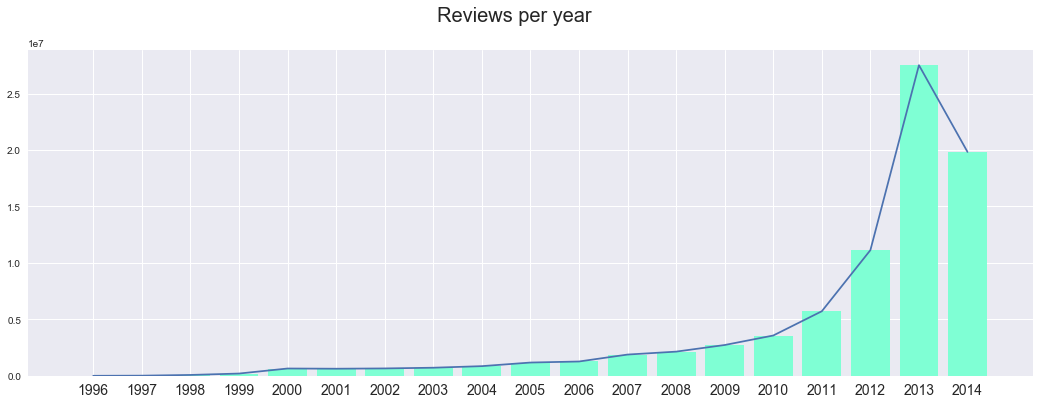

In [111]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Reviews per year', fontsize='20')
x, y = zip(*sorted(year_frequency.items())) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.bar(x,y, color='aquamarine')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize='14')
plt.show()        

What we have here is the general movement of the number of reviews done per year, it does not distinguish by category.
We can see that the amount of reviews for the first years was much smaller compared with the one that we actually have. There is a huge increase on reviews for the last few years, with a peak on 2013 and almost stable for 2014, it would be interesting having the next years number of reviews to check if it has continued increasing or if the number of reviews on amazon have reached its limit.

One engagement point from this graph is that visually the tendency seems to be logarithm so we are going to plot it with a logarithm y axis to test if we are right.


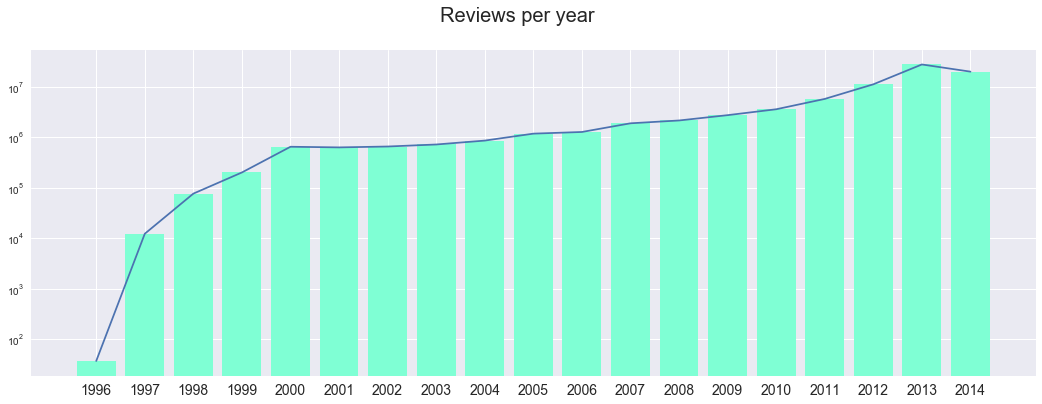

In [112]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Reviews per year', fontsize='20')
x, y = zip(*sorted(year_frequency.items())) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.bar(x,y, color='aquamarine')
ax.set_yscale('log')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize='14')
plt.show()     

This plot shows that from 2003 to 2012, approximately, the it follows a exponential fuction, increasing rapidly from 1998 to 1999, what makes sense because the tendency that Amazon followed during it beginnings.

#### Evolution of ratings per year by category

Now that we have a general idea of how reviews tendency has changed we are going to see if the movement has been the same for every category.

In [6]:
year_frequency = [{} for i in range(num_categories)] #Array (for every cat) of dicts with keys as years and values as frequency of appearance
months_frequency = [{} for i in range(num_categories)] #Array (for every cat) of dicts with keys as moths and values as frequency of appearance


#We do this because we need the list for the next section (articles/year)
# Go through every category, then every review and include the year of the review to a list.
for i in range (num_categories):
    #, we dont save the values from previous categorys because we are not going to use
    years_cat = [] #List of every year for category
    months_cat = [] #List of every year for category
    for j in range(len(rating_df[i])):
        time = dt.fromtimestamp(rating_df[i]['timestamp'][j])
        years_cat.append(time.year)
        months_cat.append(time.month)
    year_frequency[i] = Counter(years_cat)
    months_frequency[i] = Counter(months_cat)


583933
0
2638172
1
1373768
2
915446
3
2023070
4
22507155
5
3749004
6
3447249
7
5748920
8
836006
9
7824482
10
1297156
11
2982326
12
4253926
13
3205467
14
4607047
15
500176
16
1243186
17
993490
18
1235316
19
3268695
20
1926047
21
2252771
22
1324753
23


In [7]:
year_frequency

[Counter({1999: 1,
          2000: 9,
          2001: 6,
          2002: 8,
          2003: 8,
          2004: 15,
          2005: 66,
          2006: 300,
          2007: 2760,
          2008: 5081,
          2009: 5604,
          2010: 5759,
          2011: 9563,
          2012: 39500,
          2013: 237195,
          2014: 278058}),
 Counter({2002: 1,
          2003: 1,
          2005: 3,
          2006: 3,
          2007: 6,
          2008: 8,
          2009: 14,
          2010: 14,
          2011: 101955,
          2012: 635614,
          2013: 1128290,
          2014: 772263}),
 Counter({1999: 10,
          2000: 34,
          2001: 49,
          2002: 58,
          2003: 108,
          2004: 207,
          2005: 583,
          2006: 1965,
          2007: 8192,
          2008: 12988,
          2009: 22342,
          2010: 46396,
          2011: 96782,
          2012: 204050,
          2013: 562077,
          2014: 417927}),
 Counter({2000: 57,
          2001: 860,
          2002

In [8]:
months_frequency

[Counter({1: 63204,
          2: 81593,
          3: 66416,
          4: 59452,
          5: 55199,
          6: 48933,
          7: 53638,
          8: 29198,
          9: 30638,
          10: 29031,
          11: 26732,
          12: 39899}),
 Counter({1: 321689,
          2: 266063,
          3: 289136,
          4: 243489,
          5: 228066,
          6: 250980,
          7: 236256,
          8: 150223,
          9: 132173,
          10: 134867,
          11: 155853,
          12: 229377}),
 Counter({1: 131261,
          2: 112586,
          3: 129472,
          4: 127587,
          5: 135120,
          6: 139691,
          7: 136693,
          8: 86717,
          9: 81547,
          10: 89511,
          11: 87026,
          12: 116557}),
 Counter({1: 95732,
          2: 79791,
          3: 89455,
          4: 82331,
          5: 82331,
          6: 82803,
          7: 78573,
          8: 60759,
          9: 56783,
          10: 60333,
          11: 63006,
          12: 83549}),


The following cell allows us to plot the number of reviews per year considering the 24 categories. The first graph is on a normal scale whereas the second one is with log-scale.

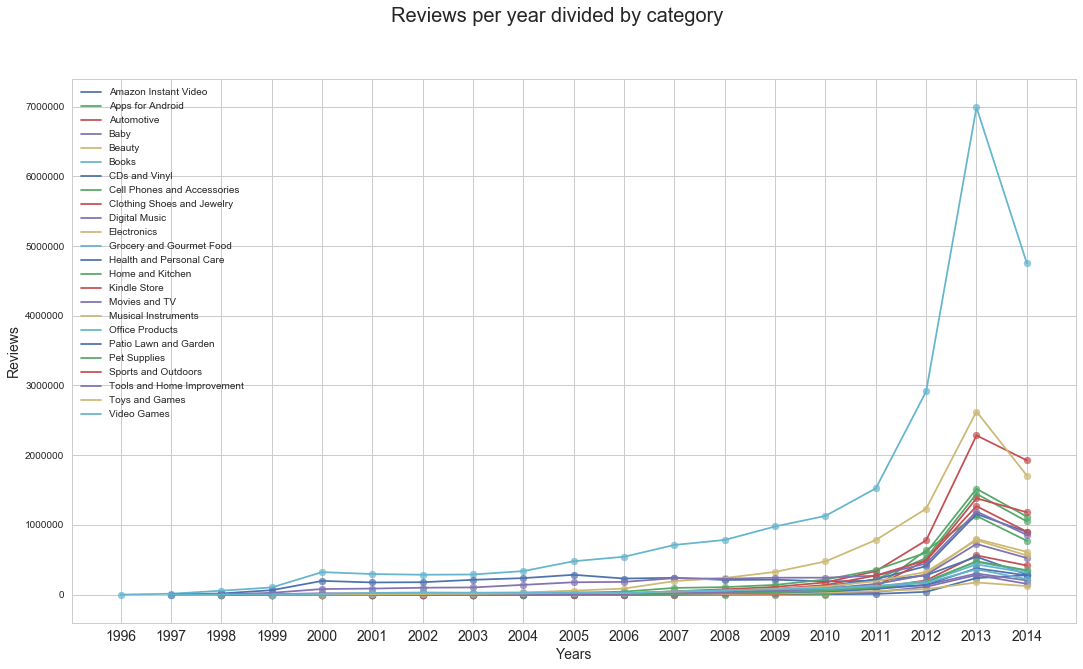

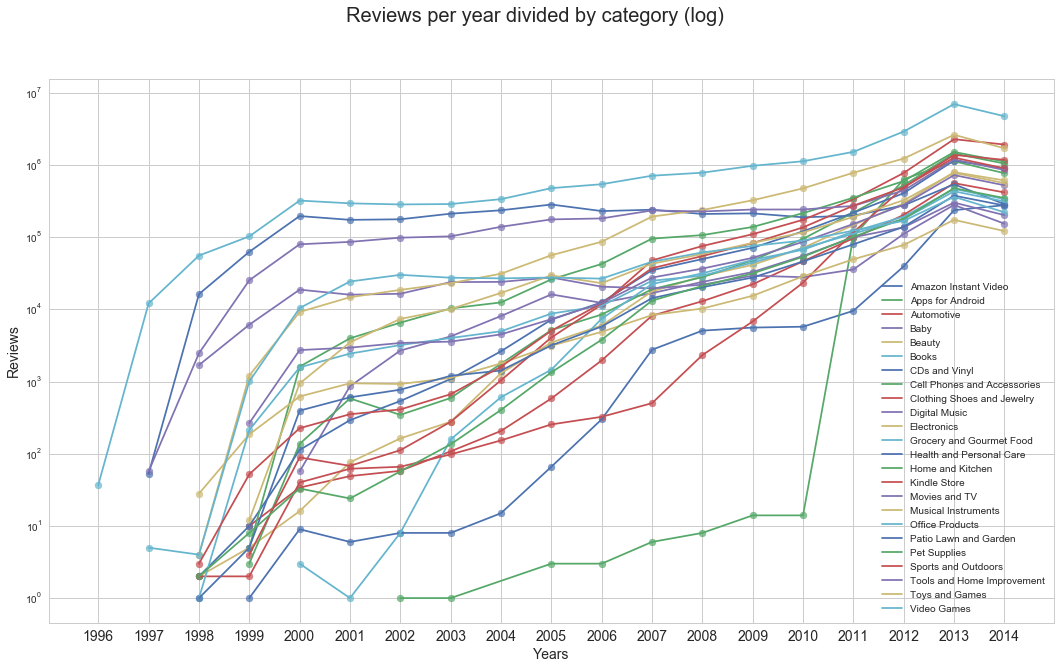

In [42]:
fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per year divided by category', fontsize='20')

for i in range (num_categories):
    x, y = zip(*sorted(year_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories)
plt.xticks(np.arange(1996, 2014 + 1, 1.0), fontsize='14')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()        


fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per year divided by category (log)', fontsize='20')

for i in range (num_categories):
    x, y = zip(*sorted(year_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories)
plt.xticks(np.arange(1996, 2014 + 1, 1.0), fontsize='14')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
ax.set_yscale('log')
plt.show()    

These graphs show us the overall increase of reviews per year (without considering the year 2014).

Looking at the log-scale graph gives more precise results for each category. It can be seen that for different categories, the number of reviews per year has sometime decreased, or has jumped consequently. These categories are sometimes "ahead" of their time, before being generalised and more accessible.

As the years pass, the trends seem to be less and less varying, leading to one unique trend.

<br><br>
The same process is applied to reviews in the cell below but this time we consider the timescale for each month instead of each year.

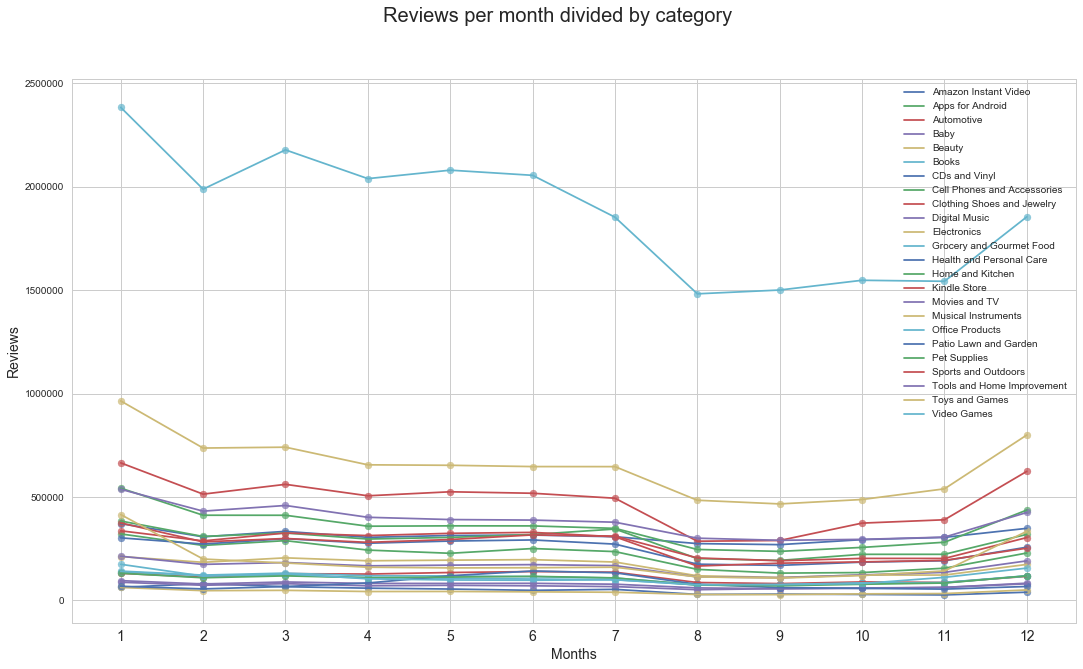

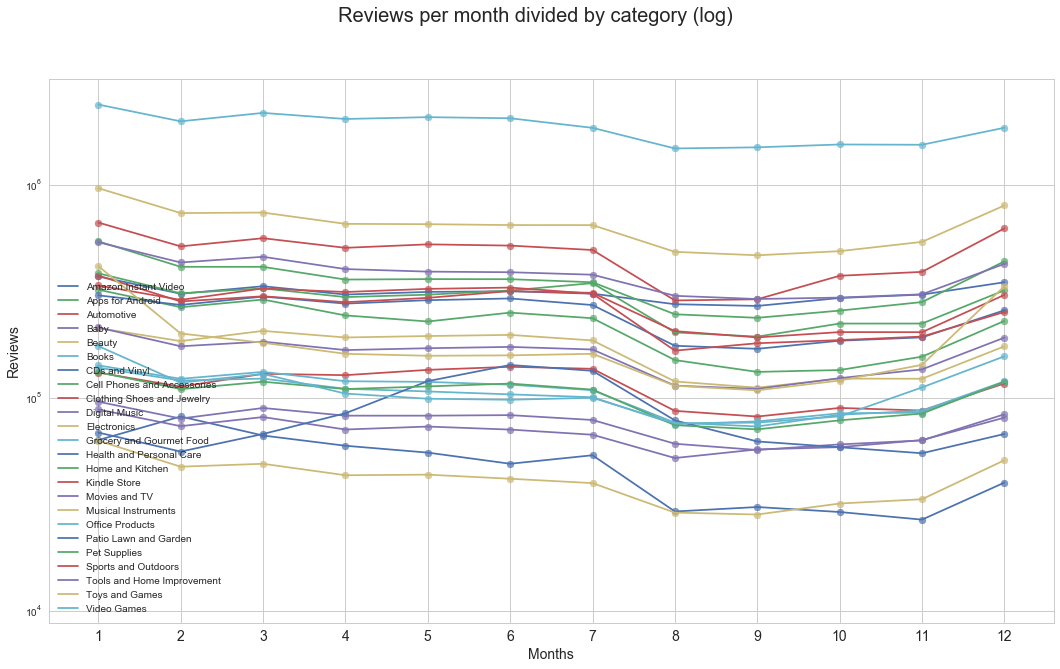

In [43]:
fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per month divided by category', fontsize='20')

for i in range (num_categories):
    x, y = zip(*sorted(months_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories)
plt.xticks(np.arange(1, 12 + 1, 1.0), fontsize='14')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()        


fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per month divided by category (log)', fontsize='20')

for i in range (num_categories):
    x, y = zip(*sorted(months_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories)
plt.xticks(np.arange(1, 12 + 1, 1.0), fontsize='14')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
ax.set_yscale('log')
plt.show()    

As it is difficult understanding the previous graph due to the fact that there are many categories, we are going to divide each plot into two, so that is easier to read, even though there some categories such as the books one that outstands from the rest.

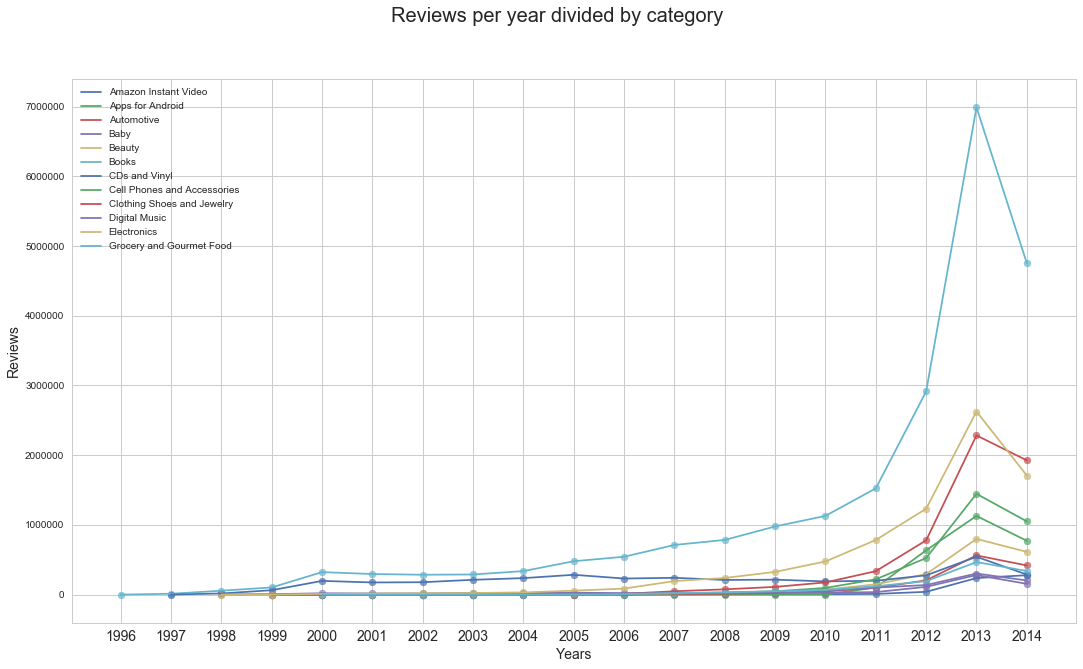

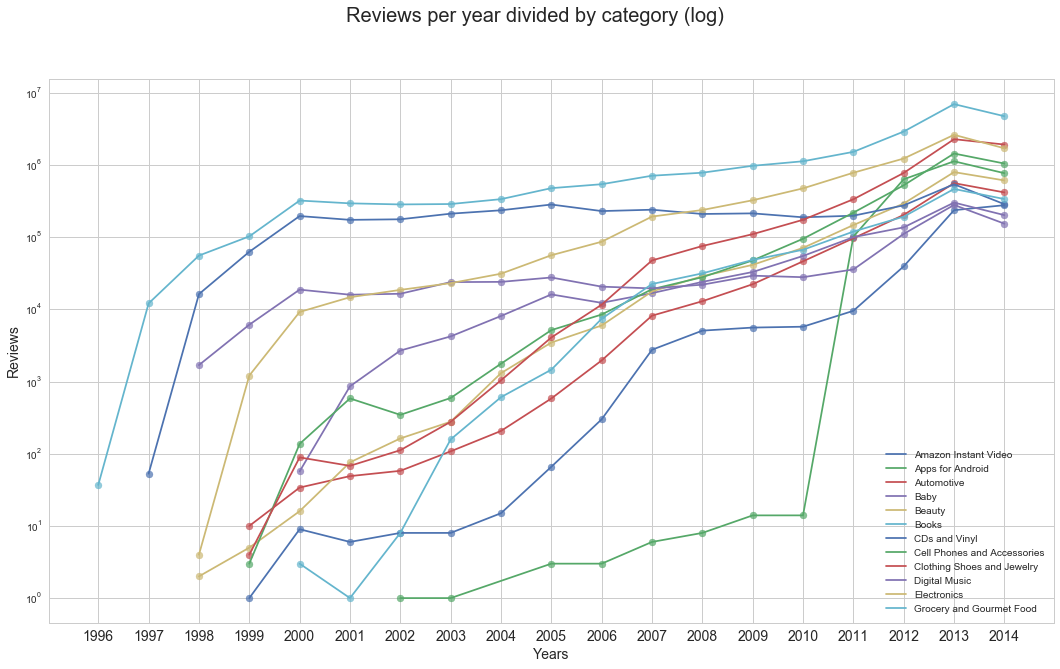

In [77]:
# Plots for years, part 1
fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per year divided by category', fontsize='20')

for i in range(int(num_categories/2)):
    x, y = zip(*sorted(year_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[:int(num_categories/2)])
plt.xticks(np.arange(1996, 2014 + 1, 1.0), fontsize='14')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()        


fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per year divided by category (log)', fontsize='20')

for i in range(int(num_categories/2)):
    x, y = zip(*sorted(year_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[:int(num_categories/2)])
plt.xticks(np.arange(1996, 2014 + 1, 1.0), fontsize='14')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
ax.set_yscale('log')
plt.show()

From this evolution along years we can see that the books category is been always the top rated, followed by *Electronics*, another of the top categories on Amazon, and *Clothing Shoes and Jewelry*. Apart from that, could also surprise that *Apps for Android* category has an incredible increase of ratings from 2010 to 2011 but this is the sample of the importance of the Amazon App Store. This contrast with *CDs and Vinyl* category, that had increased very rapidly during its firsts years but then it has remained stable, what could be a sign that though the general number of reviews is constantly increasing on Amazon *non digital music* is a bit old-fashioned.

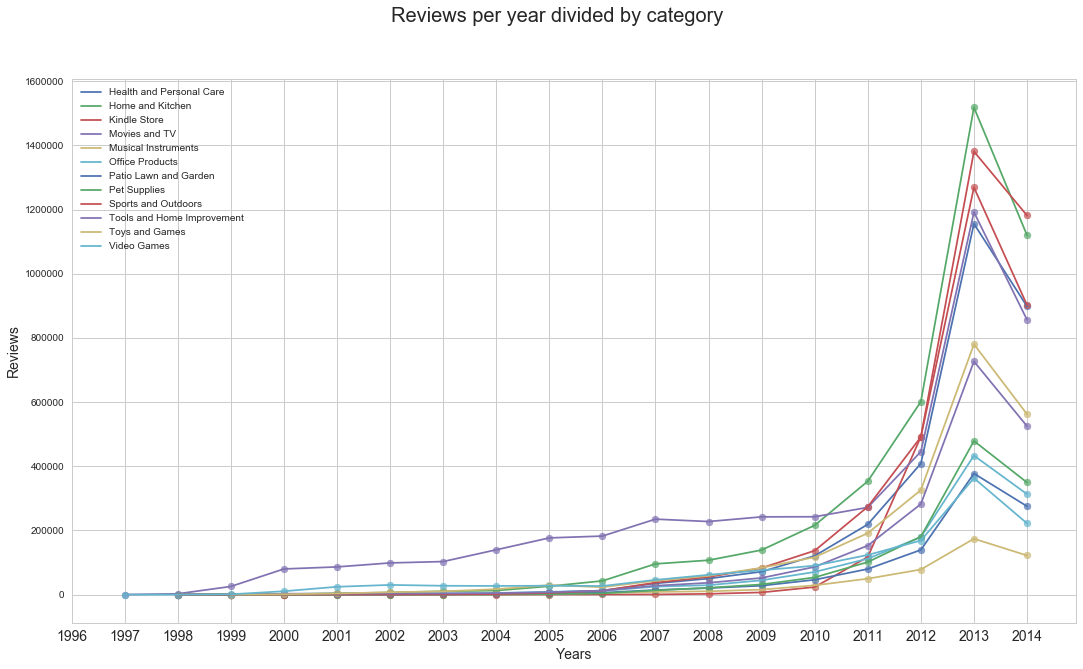

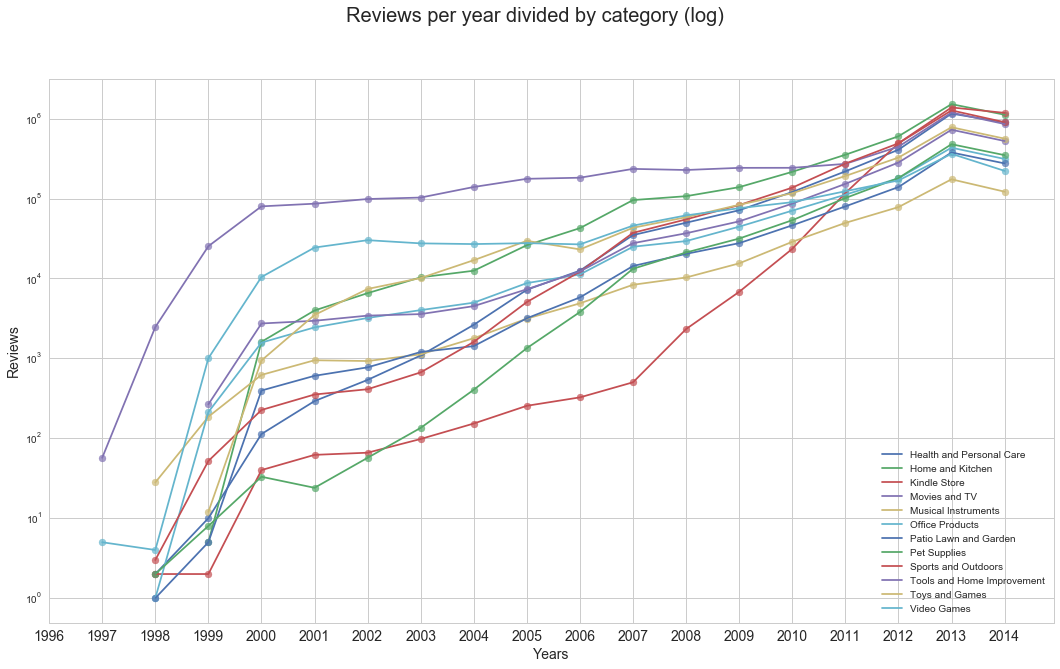

In [97]:
# Plots for years, part 2
fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per year divided by category', fontsize='20')

for i in range(int(num_categories/2), num_categories):
    x, y = zip(*sorted(year_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[int(num_categories/2):])
plt.xticks(np.arange(1996, 2014 + 1, 1.0), fontsize='14')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()        


fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per year divided by category (log)', fontsize='20')

for i in range(int(num_categories/2), num_categories):
    x, y = zip(*sorted(year_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[int(num_categories/2):])
plt.xticks(np.arange(1996, 2014 + 1, 1.0), fontsize='14')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
ax.set_yscale('log')
plt.show()

Again, all categories tend to the similar values. But this time is necessary to highlight *Health and Personal Care category*, with a good beggining, as *Video Games*, with a really good tendency during its first moments. Tecnology also make a difference this time, we can see that *Kindle Store* category starts increasing faster from 2007.

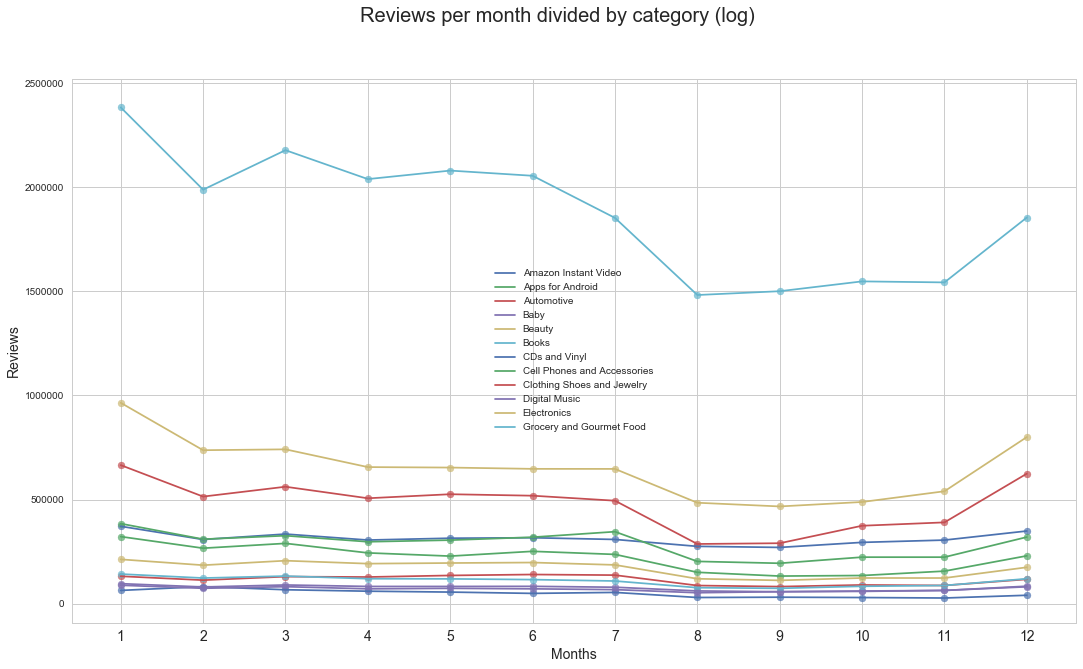

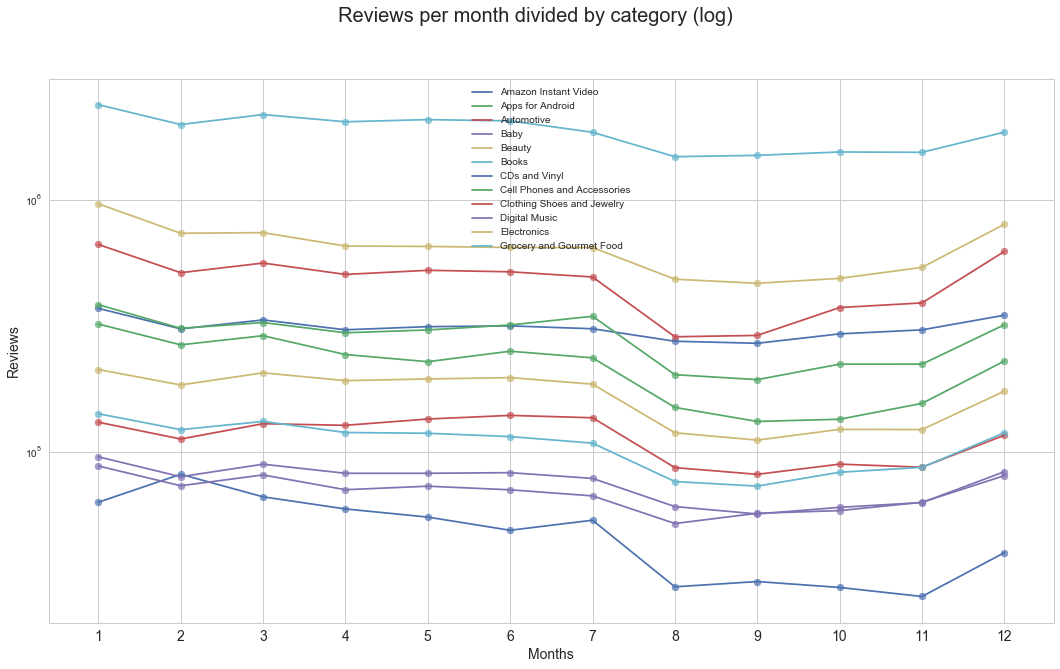

In [52]:
# Plots for months, part 1
fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per month divided by category (log)', fontsize='20')

for i in range (int(num_categories/2)):
    x, y = zip(*sorted(months_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[: int(num_categories/2)])
plt.xticks(np.arange(1, 12 + 1, 1.0), fontsize='14')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()

fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per month divided by category (log)', fontsize='20')

for i in range (int(num_categories/2)):
    x, y = zip(*sorted(months_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[:int(num_categories/2)])
plt.xticks(np.arange(1, 12 + 1, 1.0), fontsize='14')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
ax.set_yscale('log')
plt.show()

Again, *Books* is the best category. What is interesting to see here is the general tendency of every category, most of them have their top months during January, then a stable period upto July, and after that , the folling months before December are tranquil. There are some categories, such as *CDs and Vinils* where the tendency is really stable along all the year.

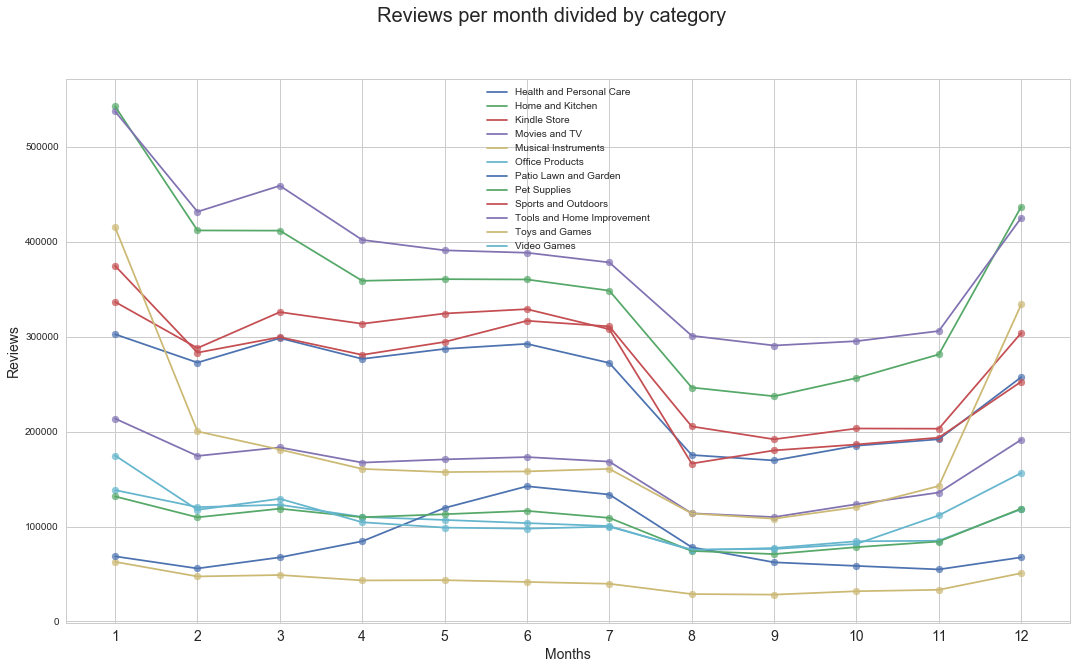

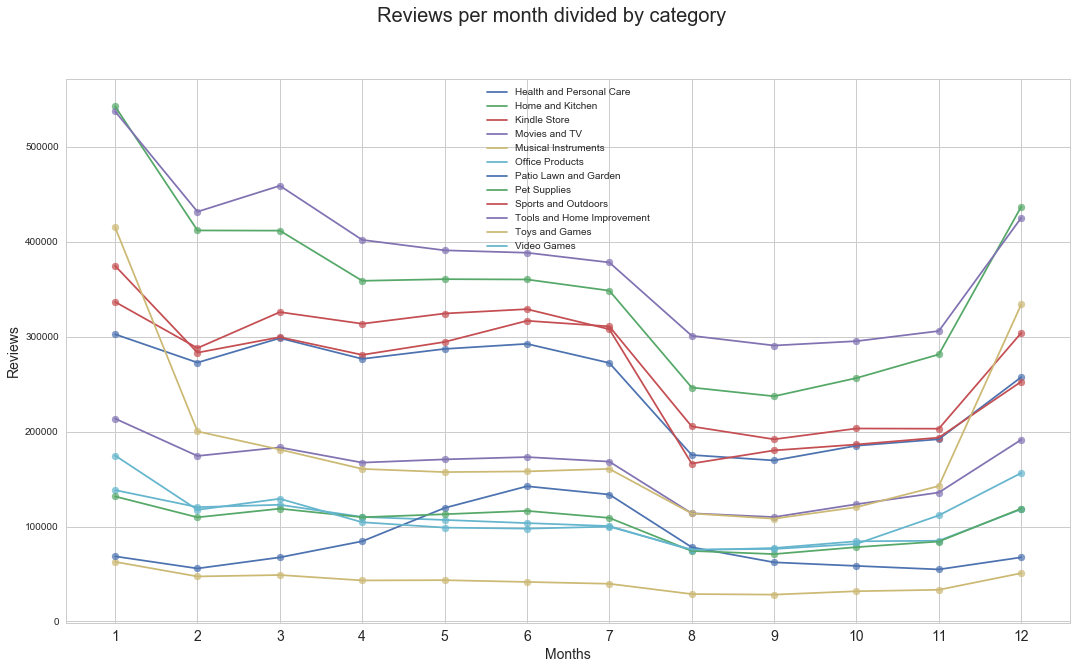

In [53]:
# Plots for months, part 2
fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per month divided by category', fontsize='20')

for i in range (int(num_categories/2), num_categories):
    x, y = zip(*sorted(months_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[int(num_categories/2):])
plt.xticks(np.arange(1, 12 + 1, 1.0), fontsize='14')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()        


fig, ax = plt.subplots(figsize = (18,10))
plt.suptitle('Reviews per month divided by category', fontsize='20')

for i in range (int(num_categories/2), num_categories):
    x, y = zip(*sorted(months_frequency[i].items())) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    plt.scatter(x,y, alpha=0.7)

ax.legend(rating_categories[int(num_categories/2):])
plt.xticks(np.arange(1, 12 + 1, 1.0), fontsize='14')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()  

This second part follows the same schema, but we should say that *Toys and Games* category is making a difference, with high decrease on ratings from January to Febrary and a high increase from November to December, we all know that Santa is playing an important role on this. 

All categories toguether:

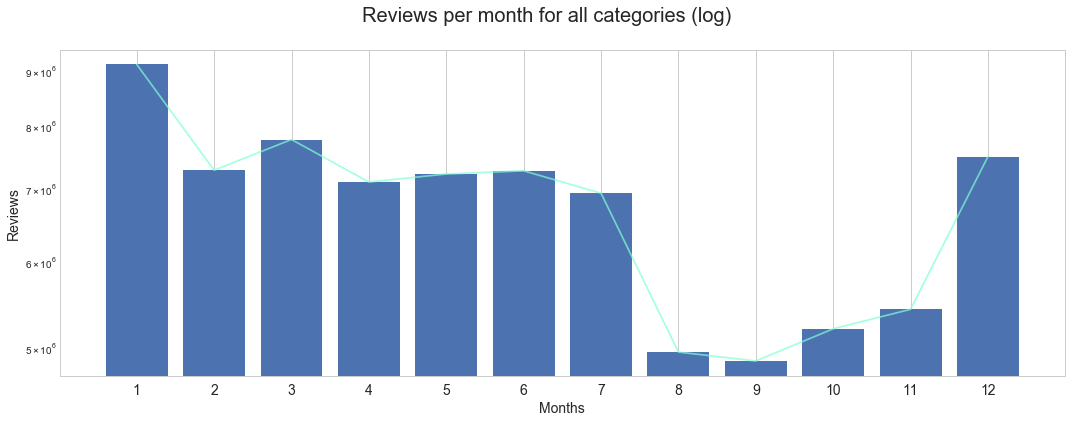

In [108]:
c_months_total_categories = Counter()

for months_category in months_frequency:
    c_months_total_categories += Counter(months_category)
        
    
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Reviews per month for all categories (log)', fontsize='20')
x, y = zip(*sorted(c_months_total_categories.items())) # unpack a list of pairs into two tuples
plt.bar(x, y)
plt.plot(x,y, color='aquamarine', alpha=0.7)
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize='14')
ax.set_yscale('log')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()  

As mentioned, January is the best ratings month, with some surprising values for September to November.


Now we are going to compare some interesting categories reviews with real data. 
For example, does it affect the number of births to the babys category. Or, does the fact that everyone join gyms right after new year affect the ratings of sports products?

#### Births
Data for USA.
Source: http://data.un.org/Data.aspx?d=POP&f=tableCode%3A55

In [109]:
mypath_other = "data/other" 
mypath_other_spain = mypath_other + "/usa_births.csv"


test_birth = pd.read_csv(mypath_other_spain, usecols=['Country or Area', 'Year', 'Month', 'Value'])
test_birth

births_month = {} #Dict containing the sum per month of all births

min_year = min(year_frequency[rating_categories.index("Baby")].keys())
for row in test_birth.iterrows():
    if (min_year > 1998) :
        try:
            births_month[row[1]['Month']] += row[1]['Value']
        except KeyError:
            births_month[row[1]['Month']] = row[1]['Value']
    else:
        break

births_month.pop('Total') #Quit unuseful values

160771546

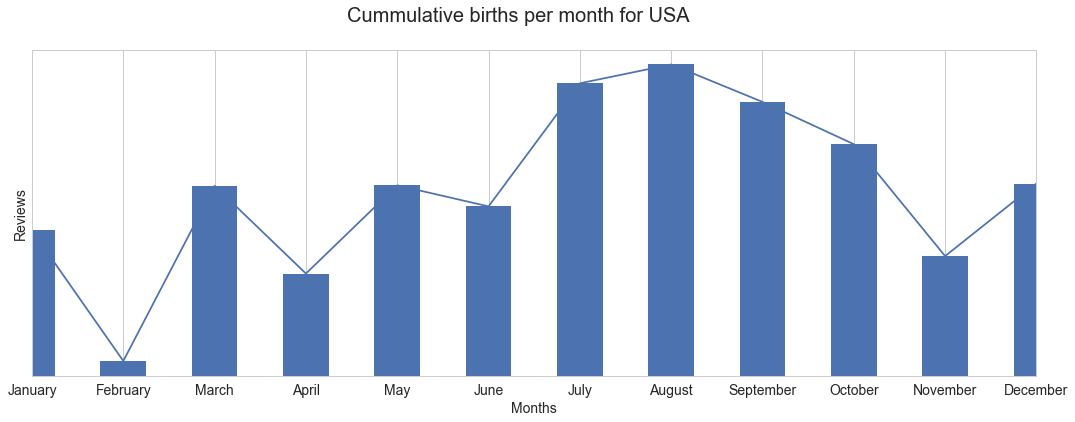

In [112]:
# Plots
fig, ax = plt.subplots(figsize = (18,6))
fig.canvas.draw()
pd.DataFrame((list(births_month.values())))[0].plot(kind='bar')
pd.DataFrame((list(births_month.values())))[0].plot()
fig.suptitle('Cummulative births per month for USA', fontsize='20')
ax.set_xticklabels( births_month.keys(), fontsize='14')
ax.set_yscale('log') #To do differences bigger
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()


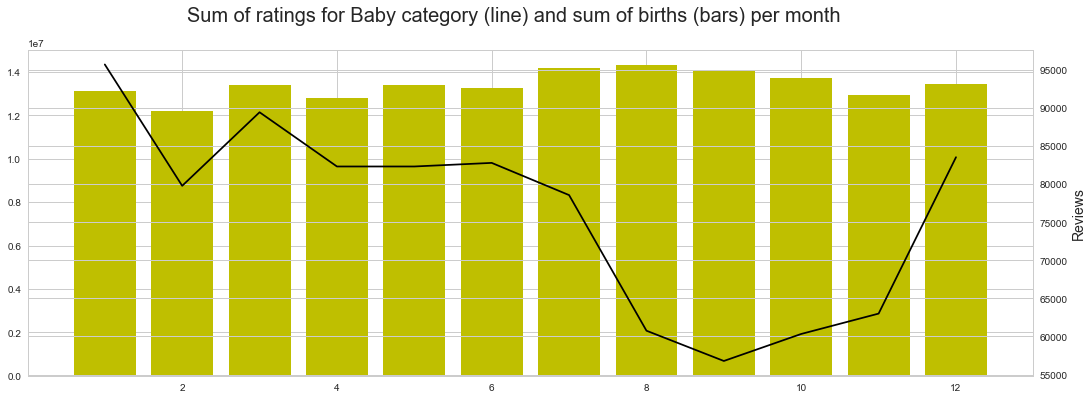

In [113]:
fig = plt.figure(figsize = (18,6))
x, y = zip(*sorted(months_frequency[rating_categories.index("Baby")].items())) 

ax1 = fig.add_subplot(111)
ax1.bar(x,list(births_month.values()),color='y')   

ax2 = ax1.twinx()
ax2.plot(x,y,'k-')   
fig.suptitle('Sum of ratings for Baby category (line) and sum of births (bars) per month', fontsize='20')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.show()

Appartenly there are not many coincidences, for example, for the first four months the reviews frequency and the births follows the same tendency, but for the next months it doesn't happend, mainly, from July to October the tendency is almost the contrary. 
For been sure, let's check the correlation:

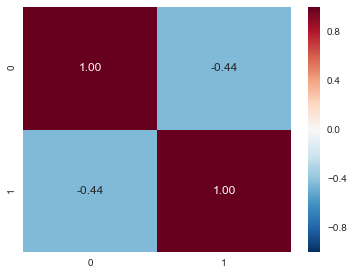

In [114]:
births_ratings = pd.DataFrame(data = [y, births_month.values()]).transpose()

fig = plt.figure(figsize = (6,4.5))
sns.heatmap(births_ratings.corr(), annot=True, fmt=".2f")
plt.show()

Analysing this results, we haven't got what we were expecting. Which would have been a positive correlation value close to 1, instead of that, we have got a negative low correlation. Because of this, we can conclude that there is no relation between births and reviews on Amazon from 2000 to 2014. This result may be due to the fact that we are not analysing sells but ratings and that baby's products aren't mainly purchased when the birth but also the previous and later months.

Althought we know that our data is not perfect, we will also try to find if there's relation between Sports reviews and sports periods. Are the number of reviews increasing for the main months when people join gym, as for January and the months before summer? 

#### Sports
For this, we are going to check the amount of ratings for the **Sports category**.

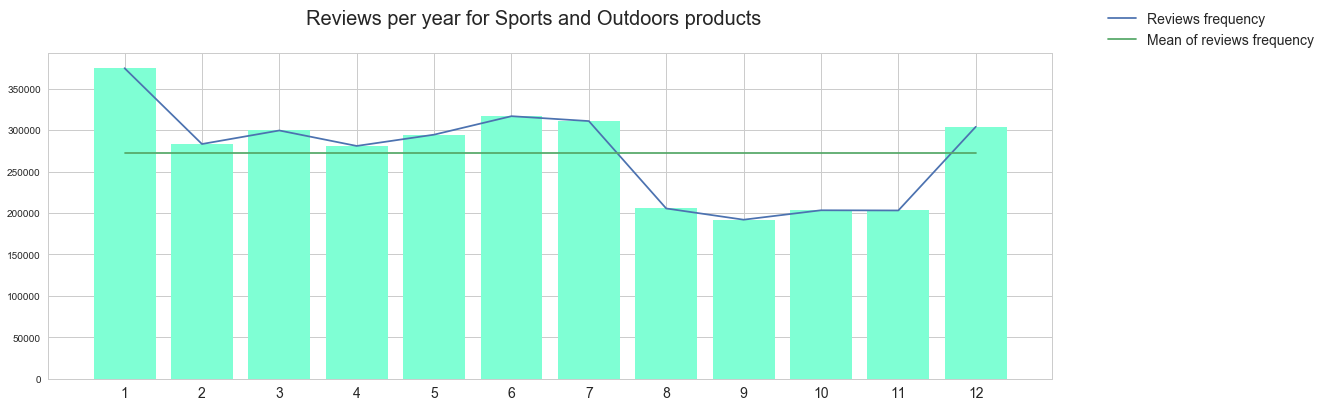

In [116]:
mean_sports_ratings = [np.mean(list(months_frequency[rating_categories.index("Sports and Outdoors")].values()))]*12
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Reviews per year for Sports and Outdoors products', fontsize='20')
x, y = zip(*sorted(months_frequency[rating_categories.index("Sports and Outdoors")].items())) 
plt.plot(x, y, label='Reviews frequency')
plt.plot(x, mean_sports_ratings, label='Mean of reviews frequency')
plt.bar(x,y, color='aquamarine')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize='14')
plt.legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., fontsize='14')
plt.show()     

What we can see from this graph for the sports category is that the great amount of reviews, and we understand that sells too, are concentrated during the months previous to the summer, with some growth for June and July and then, they start increasing again for December and defenitly for January. During August and the months after the number of reviews is very small compared to the mean as we can see in the previous figure.

#### Office products ratings
Is there an increase of the ratings on August and September because of children going back to school and adults going back work?

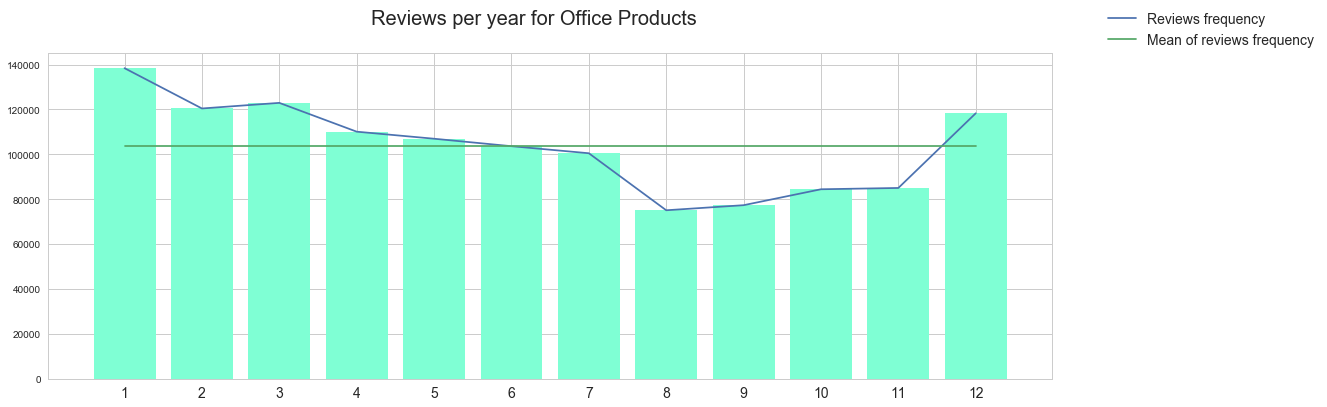

In [117]:
mean_sports_ratings = [np.mean(list(months_frequency[rating_categories.index("Office Products")].values()))]*12
# Plots
fig, ax = plt.subplots(figsize = (18,6))
plt.suptitle('Reviews per year for Office Products', fontsize='20')
x, y = zip(*sorted(months_frequency[rating_categories.index("Office Products")].items())) 
plt.plot(x, y, label='Reviews frequency')
plt.plot(x, mean_sports_ratings, label='Mean of reviews frequency')
plt.bar(x,y, color='aquamarine')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize='14')
plt.legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., fontsize='14')
plt.show()     

Again, we have a really similar tendency to the previous one, with data until August above the mean and then December again with the amount of ratings increasing. Again, we cannot confirm that there's a relation between this phenomenon and the reviews for the category studied.

<br><br>
## Q2: Is there relation between price of the product and the amount of reviews?

Analysis of the relation between product prices and reviews:
* Prices are in the metadata.json.gz
* Number of reviews are in the rating_df

First, let's analyse the price distribution for different categories.

In [7]:
pricesMI = {}

for review in parse("data/metadata/meta_Musical_Instruments.json.gz"):
    review = json.loads(review)
    try:
        pricesMI[review['asin']]=review['price'] 
    except KeyError:
        pass

The following graph is a cumulative frequency distribution of the prices.

It is useful way to see how the price ranges evolve.

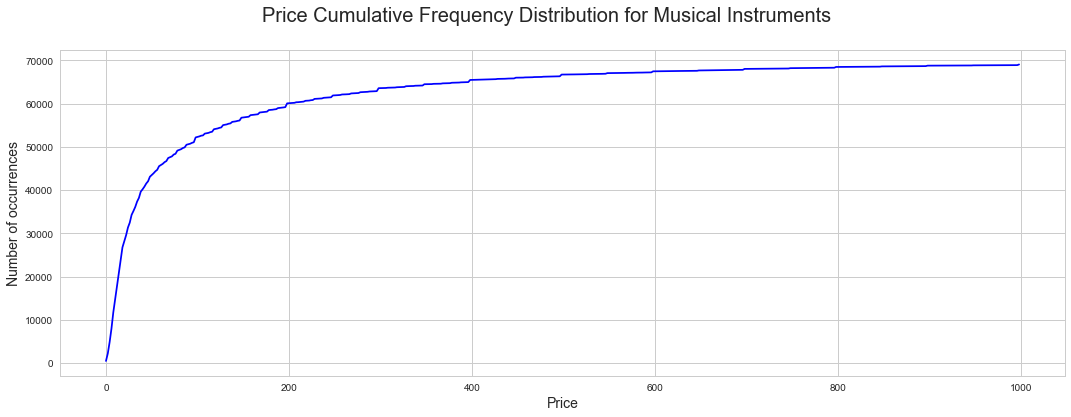

In [119]:
fig, ax =plt.subplots(figsize=(18,6))

# evaluate the histogram
values, base = np.histogram(list(pricesMI.values()), bins=500)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

fig.suptitle('Price Cumulative Frequency Distribution for Musical Instruments', fontsize=20)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Number of occurrences', fontsize=14)

plt.show()

The following graph corresponds to the price for each product available in one category (musical instruments). As expected, when the prices increase, the frequencies fluctuate consequently. 

This is the result of uneven distribution of prices between ranges of same size.

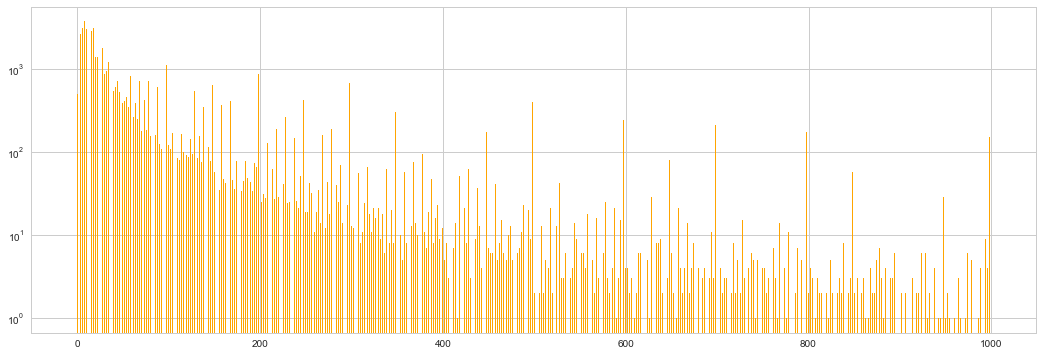

In [120]:
fig, ax =plt.subplots(figsize=(18,6))

plt.bar(base[:-1],values, color='orange', alpha=1)
ax.set_yscale('log')

plt.show()

Price per product available on Amazon. 

As expected, when the prices increase, the frequencies fluctuate consequently. 

This is the result of uneven distribution of prices between ranges of same size.

The number of music with a price of 0 is non-negligable. This might be explained by the fact that music can be free.

Let's focus for the moment on the distribution of prices for the music industry:

In [8]:
metadata_files=[x[8:].replace('.csv', '.json.gz') for x in rating_files]

Using a for loop, we read the price value, if it exists, for each review of the *metadata.json.gz* file.



In [9]:
pricesDM = {}

for review in parse("data/metadata/meta_Digital_Music.json.gz"):
    review = json.loads(review)
    try:
        pricesDM[review['asin']]=review['price'] 
    except KeyError:
        pass

In [10]:
pricesCDV = {}

for review in parse("data/metadata/meta_CDs_and_Vinyl.json.gz"):
    review = json.loads(review)
    try:
        pricesCDV[review['asin']]=review['price'] 
    except KeyError:
        pass

We plot the distribution of the prices for every product of the categories linked to music.

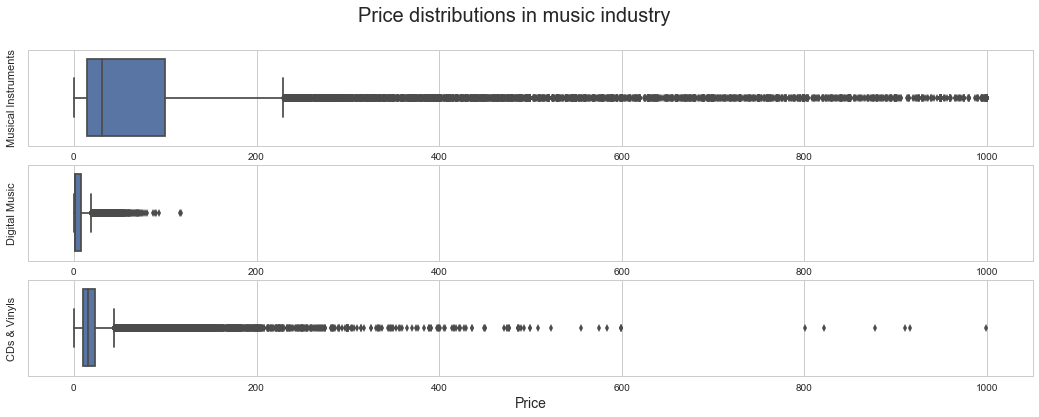

In [125]:
fig, ax =plt.subplots(3,1, figsize=(18,6))

sns.boxplot(list(pricesMI.values()), orient = "h", ax=ax[0])
sns.boxplot(list(pricesDM.values()), orient = "h", ax=ax[1])
sns.boxplot(list(pricesCDV.values()), orient = "h", ax=ax[2])

fig.suptitle('Price distributions in music industry', fontsize=20)
plt.xlabel('Price', fontsize=14)

ax[0].set_xlim([-50,max(pricesMI.values())+50])
ax[1].set_xlim([-50,max(pricesMI.values())+50])
ax[2].set_xlim([-50,max(pricesMI.values())+50])

ax[0].set_ylabel('Musical Instruments')
ax[1].set_ylabel('Digital Music')
ax[2].set_ylabel('CDs & Vinyls')


plt.show()

Even though each distribution has a similar trend (largely skewed), the range of values is hardly comparable. Downloading songs tend to be cheaper than songs on a solid media (CDs or Vinyls) which are generally cheaper than musical instruments.

We now repeat the same process but this time for the entire dataset in mypath:

In [11]:
prices_all={}
l_all = []

metadata_files=[x[8:].replace('.csv', '.json.gz') for x in rating_files]

for i in range(num_categories):
    for review in parse("data/metadata/meta_" + metadata_files[i]):
        review = json.loads(review)
        try:
            prices_all[review['asin']]=float(review['price'])
        except KeyError:
            pass
    l_all.append(list(prices_all.values()))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


The following cell allows us to compute for each category the distribution and the cumulative frequency distribution of price using a *for* loop.

In [12]:
lv=[]
lb=[]
lc=[]

for i in range(num_categories):
    #value, base = np.histogram(sorted(l_all[i]), bins=5000)
    value, base = np.histogram(sorted(l_all[i]), bins=5000, normed=True)
    lv.append(value)
    lb.append(base[:-1])
    
    cumulative = np.cumsum(value)
    lc.append(cumulative)

The following cell plots the cumulative frequency distribution of price for each category.

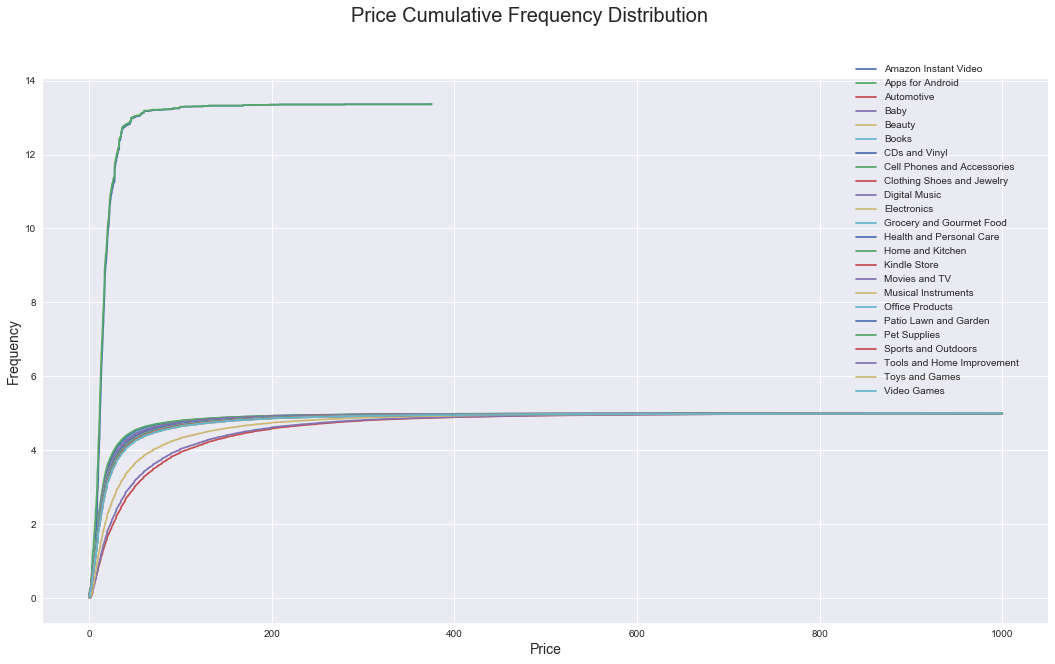

In [26]:
fig = plt.figure(1, figsize=(18,10))

ax = fig.add_subplot(111)

for i in range(num_categories):
        ax.plot(lb[i],lc[i],linestyle='-')

fig.suptitle('Price Cumulative Frequency Distribution', fontsize=20)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

ax.legend(rating_categories, bbox_to_anchor=(0.8,0.4))
#ax.legend()

plt.show()

**Reviews vs Price**

Count the number of reviews by counting every occurences of each product, *asin*, for Music Instruments.

In [28]:
c = Counter()

for i in range(num_categories):
    ci = Counter(rating_df[i]['asin'])
    c += ci


Now, we count the total number of reviews *c[i]* per price, considering the products with a price in their description. We are now considering only the 3 categories from the music industry.

In [15]:
cntMI = Counter()
cntDM = Counter()
cntCDV = Counter()

for i in pricesDM.keys():
    cntDM[pricesDM[i]] += c[i]
    
for i in pricesMI.keys():
    cntMI[pricesMI[i]] += c[i]
    
for i in pricesCDV.keys():
    cntCDV[pricesCDV[i]] += c[i]

The following scatter plot represent the overall trend between the prices and the number of reviews. The relationship described below corresponds to the values computed with histogram. We thus have one value per price range (bin width).

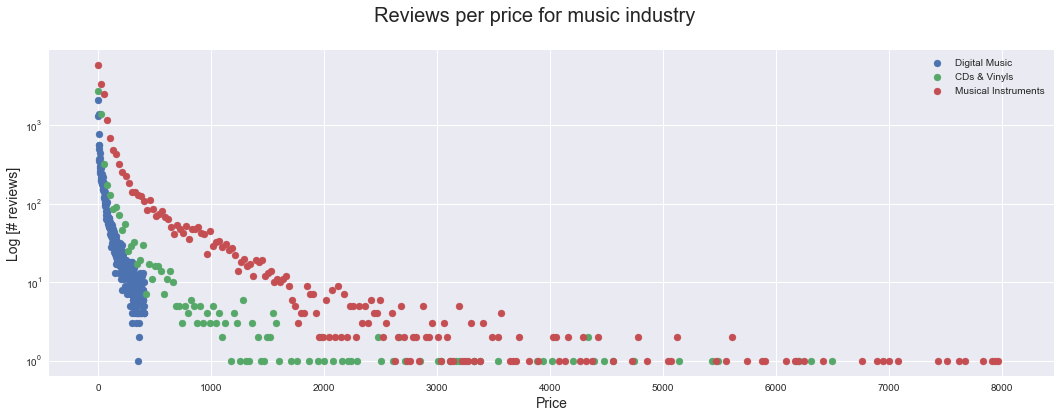

In [16]:
fig, ax =plt.subplots(figsize=(18,6))

value, base = np.histogram(sorted(cntMI.items()), bins=5000)
plt.scatter(base[:300], value[:300])
value, base = np.histogram(sorted(cntDM.items()), bins=5000)
plt.scatter(base[:300], value[:300])
value, base = np.histogram(sorted(cntCDV.items()), bins=5000)
plt.scatter(base[:300], value[:300])
ax.set_yscale('log')

fig.suptitle('Reviews per price for music industry', fontsize=20)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Log [# reviews]', fontsize=14)
ax.legend({'Musical Instruments', 'Digital Music', 'CDs & Vinyls'})

plt.show()

This plot is quite interesting has for each category, the relation between price and log(reviews) are more or less linear. The lower the price, the higher the number of reviews. 

This result could be used in parallel with the number of utilisation of each product. Indeed, product with smaller prices are more likely to be used.<br><br><br>
On the contrary, the scatterplot below shows the entire set of points (price, n° reviews). This time we have one value per product. The overall trend is still visible.

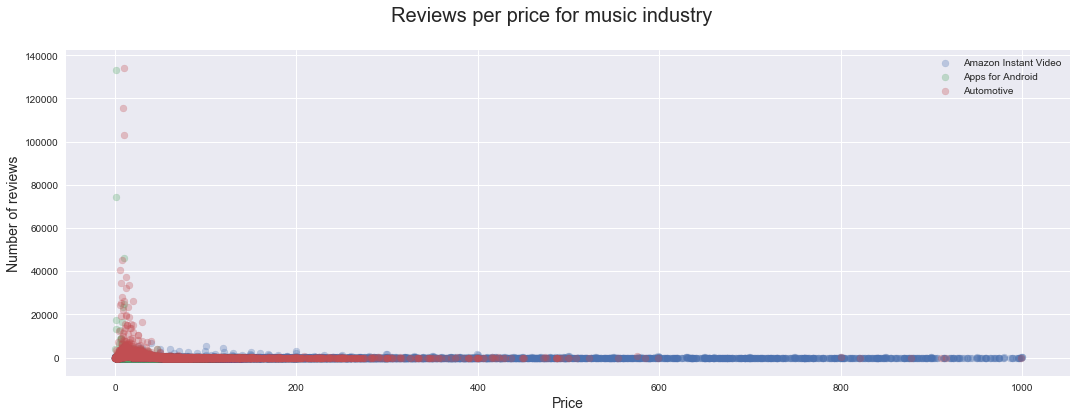

In [17]:
fig, ax =plt.subplots(figsize=(18,6))

plt.scatter(list(cntMI.keys()),list(cntMI.values()), alpha=0.3)
plt.scatter(list(cntDM.keys()),list(cntDM.values()), alpha=0.3)
plt.scatter(list(cntCDV.keys()),list(cntCDV.values()), alpha=0.3)

fig.suptitle('Reviews per price for music industry', fontsize=20)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
ax.legend(rating_categories)

plt.show()

Now, we count the total number of reviews *c[i]* per price, considering the products with a price in their description.

In [29]:
cnt_all = Counter()

for i in prices_all.keys():
    cnt_all[prices_all[i]] += c[i]

On the contrary, the scatterplot below shows the entire set of points (price, n° reviews). This time we have one value per product. The overall trend is still visible.

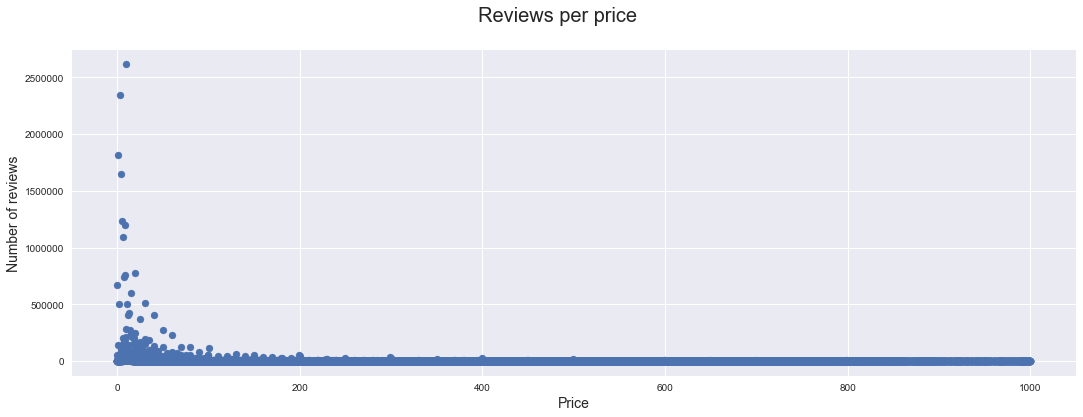

In [30]:
fig, ax =plt.subplots(figsize=(18,6))

plt.scatter(list(cnt_all.keys()),list(cnt_all.values()))

fig.suptitle('Reviews per price', fontsize=20)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)

plt.show()

<br>
## Q3: Is there relation between category of the product and the amount of reviews?

Boxplot of reviews per product per category.

In [ ]:
count = Counter()
li=[]

for i in range(num_categories):
    li.append(list(Counter(rating_df[i]['asin']).values()))

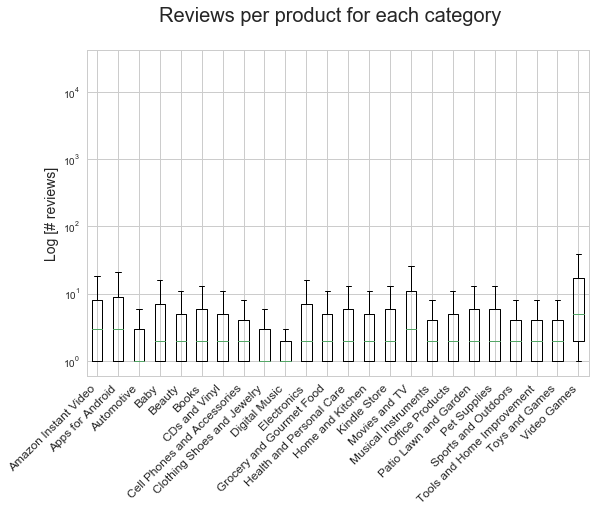

In [135]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(li)
ax.set_yscale('log')
ax.set_xticklabels(rating_categories, rotation = 45, ha="right", fontsize = 12)

fig.suptitle('Reviews per product for each category', fontsize=20)
plt.ylabel('Log [# reviews]', fontsize=14)

plt.show()

It is interesting to see the distribution of log(reviews) per category. 

There are 2 trends. Distribution with low median, distribution with median at mid-range.
For example, considering *Digital Music* or *Automotive*, the median is rather low. This means that at least 50% of the products in these categories will have a low number of reviews. 
On the contrary, in *Electronics*, *Grocey and Gourmet Food* or even in *Patio Lawn and Garden* have a rather constant number of reviews.<br><br><br>


## Q4: Are the people giving more reviews more satisfied with products?

For this question, first, we are going to take the top reviewers and check how many they do.

In [6]:
c_reviewers = Counter()

for i in range(num_categories):
    try:
        c_reviewers += Counter(rating_df[i]['reviewerID'])
    except KeyError:
        c_reviewers = Counter(rating_df[i]['reviewerID'])


c_reviewers.most_common()[:20]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


[('A14OJS0VWMOSWO', 44909),
 ('AFVQZQ8PW0L', 29430),
 ('A328S9RN3U5M68', 10922),
 ('A9Q28YTLYREO7', 8901),
 ('A320TMDV6KCFU', 7935),
 ('A13QTZ8CIMHHG4', 7193),
 ('A2EDZH51XHFA9B', 6244),
 ('A2F6N60Z96CAJI', 6148),
 ('A2AIMXT9PLAM12', 5795),
 ('A16CZRQL23NOIW', 5566),
 ('A2OJW07GQRNJUT', 5514),
 ('A1S3C5OFU508P3', 5337),
 ('A281NPSIMI1C2R', 5200),
 ('A1D2C0WDCSHUWZ', 4897),
 ('A2NJO6YE954DBH', 4836),
 ('AHD101501WCN1', 4775),
 ('A2R6RA8FRBS608', 4247),
 ('AHUT55E980RDR', 4125),
 ('A2VKWLCNZF4ZVB', 4084),
 ('A1X8VZWTOG8IS6', 4082)]

Then, we are going to plot the number of reviews per user, which could be interesting to have an idea about how many reviews are usually done.

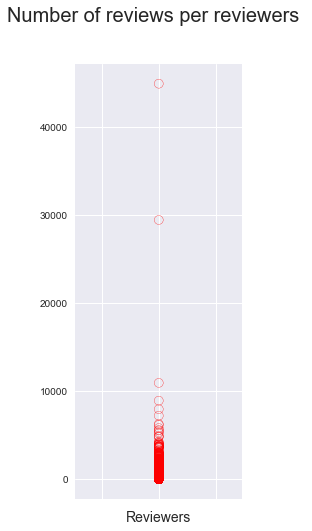

In [7]:
fig, ax =plt.subplots(figsize=(3,8))

plt.scatter([1]*len(c_reviewers), list(c_reviewers.values()), s=80, facecolors='none', edgecolors='r')
fig.suptitle('Number of reviews per reviewers ', fontsize=20)
ax.set_xticklabels('')
plt.xlabel('Reviewers', fontsize=14)

plt.show()

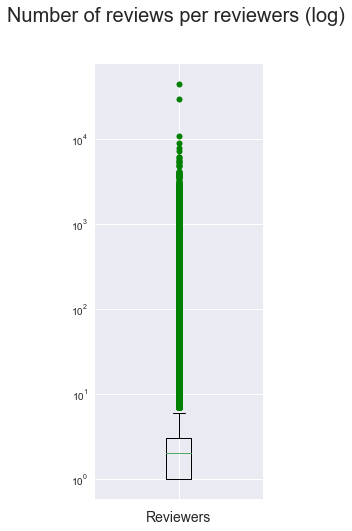

In [8]:
fig, ax =plt.subplots(figsize=(3,8))
fig.suptitle('Number of reviews per reviewers (log)', fontsize=20)
plt.boxplot(list(c_reviewers.values()), 0, 'g')
ax.set_yscale('log')
ax.set_xticklabels('')
plt.xlabel('Reviewers', fontsize=14)

plt.show()

It surprises that there are users with more than 1000 reviews, up to ~50.000!

Once we know some more information about the data we are going to use, it is about time to solve this question. To do it, we are going to take the average of ratings for all reviewers and also the average of ratings for the 1000 most reviewers.

In [10]:
c_ratings_t = Counter()
s_ratings_t = 0
len_ratings_t = 0
for i in range(num_categories):
    c_ratings_t += Counter(rating_df[i]['rating'])
    len_ratings_t += len(rating_df[i]['rating'])
    
for rating in c_ratings_t.most_common():
    s_ratings_t += rating[0]*rating[1]

mean_ratings_t = s_ratings_t/len_ratings_t

mean_ratings_t #Mean of ratings for all reviewers


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


4.1707407906463763

Percentage of apparence of each value:

In [12]:
p_ratings_t = {}
for rating in c_ratings_t.most_common():
    p_ratings_t[rating[0]] = (rating[1]/len_ratings_t)*100

p_ratings_t

{1.0: 7.866102123149347,
 2.0: 5.111196014454784,
 3.0: 8.568090135891026,
 4.0: 18.991744127618617,
 5.0: 59.46286759888623}

What we can observe is that the most common value is the 5, followed by the fourth.
Now let's try it for the top reviewers.

Some plots.

In [13]:
c_reviewers_p = c_reviewers.most_common()[:1000]

In [18]:
#To have an idea of the last values
c_reviewers_p[-10:]

[('A1XJ8BRL29EO9S', 776),
 ('A33D1LPCYUANWE', 776),
 ('A23ZNGL704AW7O', 775),
 ('A1VQBEW0G4IH1J', 775),
 ('A32EDSKLEUZ3Y7', 775),
 ('A1NJLDT5WDKD84', 775),
 ('ABLOQZIL42W7I', 774),
 ('A106016KSI0YQ', 774),
 ('AG2YXYIQ8TLTA', 774),
 ('A2IY9M330NKBW6', 773)]

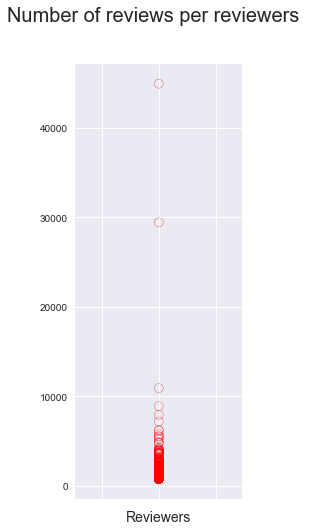

In [14]:
fig, ax = plt.subplots(figsize=(3,8))

plt.scatter([1]*len(c_reviewers_p), (list(zip(*c_reviewers_p))[1]), s=80, facecolors='none', edgecolors='r')
fig.suptitle('Number of reviews per reviewers ', fontsize=20)
ax.set_xticklabels('')
plt.xlabel('Reviewers', fontsize=14)

plt.show()

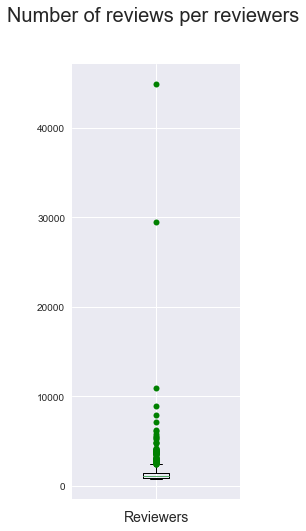

In [15]:
fig, ax =plt.subplots(figsize=(3,8))
fig.suptitle('Number of reviews per reviewers', fontsize=20)
plt.boxplot((list(zip(*c_reviewers_p))[1]), 0, 'g')
plt.xlabel('Reviewers', fontsize=14)
ax.set_xticklabels('')
plt.show()

From this boxplot, we can see that while in the previous one, for all reviewers, the percentile important values were 0, now they have move to > 800.

In [27]:
c_ratings_p = Counter()
rating_df_p= pd.DataFrame()
list_p = (list(zip(*c_reviewers_p))[0])
    
for i in range(num_categories):
    c_ratings_p += Counter((rating_df[i][['reviewerID', 'rating']])[rating_df[i]['reviewerID'].isin(list_p)]['rating'])
    
c_ratings_p.most_common()

[(5.0, 740811), (4.0, 439448), (3.0, 171766), (2.0, 56152), (1.0, 29762)]

In [30]:
s_ratings_p = 0
len_ratings_p = (sum(c_ratings_p.values()))

for rating in c_ratings_p.most_common():
    s_ratings_p += rating[0]*rating[1]

mean_ratings_p = s_ratings_p/len_ratings_p

mean_ratings_p #Mean of ratings for top reviewers

4.25554282900735

In [31]:
#Percentage of ratings for top 1000 reviewers
p_ratings_p = {}

for rating in c_ratings_p.most_common():
    p_ratings_p[rating[0]] = (rating[1]/len_ratings_p)*100

p_ratings_p

{1.0: 2.0697679108779994,
 2.0: 3.9050335236752045,
 3.0: 11.945291142391994,
 4.0: 30.56096259994339,
 5.0: 51.51894482311141}

What we can observe is that, again, the most common value is 5, followed by 4. But this time, while for the 5 has descended just a few points, it stands out that for 4 the percentaje has almost muiltiplied by two. Also surprises that for 1 the percentage is really low compared with the general rating.

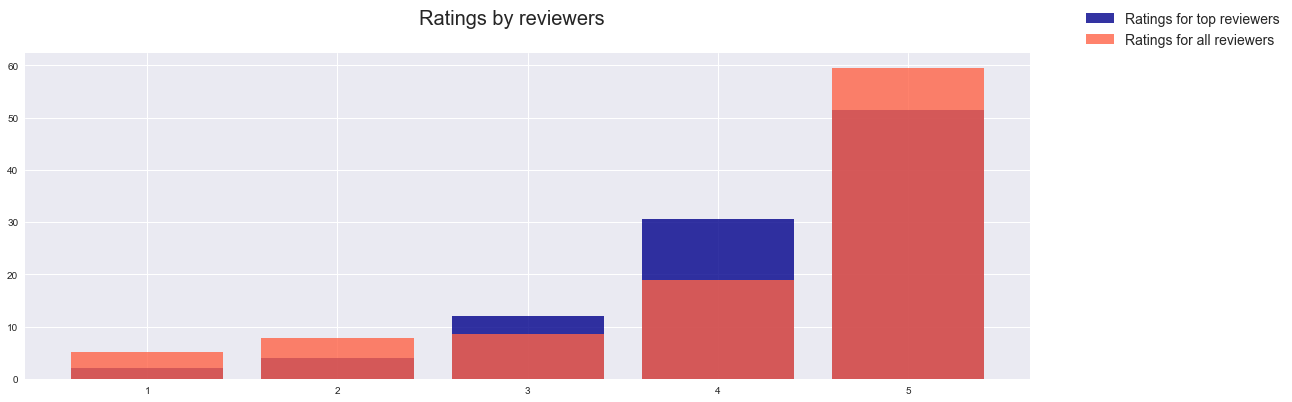

In [32]:
fig, ax =plt.subplots(figsize=(18,6))
x = [1,2,3,4,5]
fig.suptitle('Ratings by reviewers', fontsize=20)
ax.bar(x,list(reversed(list(p_ratings_p.values()))), label='Ratings for top reviewers',color='darkblue', alpha = 0.8)
ax.bar(x,list(reversed(list(p_ratings_t.values()))), label='Ratings for all reviewers',color='tomato', alpha = 0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., fontsize='14')
plt.show()


As commented, for all reviewers the ratio of 5, 1 and 2 ratings is bigger, so we can conclude that the top raters tend not to rate with low scores.

<br><br>
## Interesting data, just for curious people

* How many reviews are there?
* How many reviews have to top 3 reviewed products?
* How many products have been reviewed?
* How many reviews have done the top 3 reviewers?
* Which is the mean value for the ratings?
* In which category do people preffer rating?


#### How many reviews are there?

In [33]:
len_reviews = 0
for category in rating_df:
    len_reviews += len(category['rating'])

len_reviews

80737561

#### How many reviews have to top 3 reviewed products?

In [34]:
reviews_product = Counter()
for category in rating_df:
     reviews_product += Counter(category['asin'])

reviews_product.most_common()[:3]

[('B00DJFIMW6', 32442), ('B0054JZC6E', 25368), ('B006GWO5WK', 24452)]

#### In which category do people preffer rating?

In [42]:
len_reviews_cat = 0
name_cat_more_reviws = ""
i = 0

for category in rating_df:
    if len_reviews_cat < len(category['rating']):
        len_reviews_cat = len(category['rating'])
        name_cat_more_reviws = rating_categories[i]
    i += 1

name_cat_more_reviws

'Books'

#### How many reviews have done the top 3 reviewers?

In [9]:
#reviews_reviewers = Counter()
#for category in rating_df:
#     reviews_reviewers += Counter(category['reviewerID'])

c_reviewers.most_common()[:3]

[('A14OJS0VWMOSWO', 44909), ('AFVQZQ8PW0L', 29430), ('A328S9RN3U5M68', 10922)]

#### Which is the mean value for the ratings?

In [11]:
mean_ratings_t

4.1707407906463763

#### How many products have been reviewed?

In [7]:
len(reviews_product)

8210439

<font color='Crimson'> ** How many reviews are there? **
More than 80.000.000 reviews. </font>

<font color='navy'> **How many reviews have to top 3 reviewed products?** *About 30.000 ratings for the top products. Guess what! The top reviewed is an app, "Minion Rush: Despicable Me Official Game". Try to search for the others!*</font> 

<font color='teal'> **In which category do people preffer rating?** *Preffered category is Books* </font>

<font color='aquamarine'>**How many reviews have done the top 3 reviewers?** *One person with almost 45.000 reviews, that's hard work!* </font>

<font color='grey'> **Which is the mean value for the ratings?** Users know what they buy, mean is 4.17 </font>

<font color='chocolate'> **How many products have been reviewed?** Products reviewed: 8.210.439 </font>

<br><br>
# Conclusions

Working on this project has been a good training for our data scientific life, we have learned the basics, faced a data problem, and dealt with large datasets.

We have proven that both the number of reviews and the number of products reviewed are constantly increasing so that reviews are a key factor for Amazon.

Something we have also learned is that people tend to review (and thus to buy) more cheap products than expensive one in each category.

From question three, we could say that even though the number of reviews per product is similar between categories, there are some that out stands from the others (in particular for technology-related products).

And about satisfaction, we can definitely say that yes, those with more reviews tend to rate better, the rarely use low scores.

Handling the data, we have learned many methods that use less time and memory and so are more efficient. This can be seen along the code, with important improvements on data structures. Also that the drop of a member was a difficulty but we knew how to face it!

Finally, is this useful for social good? Definitely yes! It`s clear that reviews are helpful and take part in their purchase decisions, but they are not only done because of the motivation of knowing that you are helping someone, but also because of money and free products sometimes, so take care about what you buy and don't be influenced only by one opinion but by a mix of them, taking into account the pros and cons of products.

<br><br>
# Bibliography

Some bibliography

* https://www.britannica.com/topic/Amazoncom

* http://www.telegraph.co.uk/technology/amazon/11801515/Amazon-timeline-from-internet-bookshop-to-the-worlds-biggest-online-retailer.html

* https://digiday.com/marketing/vendors-ask-go-around-policy-confessions-top-ranked-amazon-review-writer/